In [ ]:
!pip install -q transformers
!pip install -q tokenizers
!pip install -q accelerate
!pip install -q hickle rdkit deepchem

import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, Activation,
    Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D,
    Concatenate, LayerNormalization, Add, MultiHeadAttention,
    Reshape, Multiply, Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras import mixed_precision

from transformers import AutoTokenizer, AutoModel, logging as hf_logging
hf_logging.set_verbosity_error()

from rdkit import Chem
from rdkit.Chem import AllChem
import torch
import json
from datetime import datetime

print("✓ Imports OK")

DRIVE_DATA_PATH = '/content/drive/MyDrive/DeepCDR-master/DeepCDR-master/data'
DRUG_SMILES_PATH = os.path.join(DRIVE_DATA_PATH, '223drugs_pubchem_smiles.txt')
PREDICTED_DATA_PATH = os.path.join(DRIVE_DATA_PATH, 'Missing_data_pre/records_pre_all.txt')

MORGAN_FP_SIZE = 2048
DRUG_LLM_DIM = 768

USE_PCA = True
PCA_VARIANCE_RATIO = 0.95
PCA_COMPONENTS = {
    'expression': 150,
    'methylation': 150,
    'mutation': 150
}

MAX_SAMPLES = None
BATCH_SIZE = 32

USE_LLM_DRUG = True
USE_LLM_GENOMIC = False
USE_ATTENTION_FUSION = True
USE_TRANSFORMER_OMICS = True
LLM_WEIGHT = 0.3

TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_DIR = os.path.join('/content/drive/MyDrive/', f'results_{TIMESTAMP}')
MODELS_DIR = os.path.join(OUTPUT_DIR, 'models')
PLOTS_DIR = os.path.join(OUTPUT_DIR, 'plots')
LOGS_DIR = os.path.join(OUTPUT_DIR, 'logs')

for dir_path in [OUTPUT_DIR, MODELS_DIR, PLOTS_DIR, LOGS_DIR]:
    os.makedirs(dir_path, exist_ok=True)

print(f"✓ Output directory: {OUTPUT_DIR}")


def setup_hardware():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU: {len(gpus)} device(s)")
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    return len(gpus) > 0



class HybridDrugFeaturizer:
    def __init__(self, use_llm=True):
        self.use_llm = use_llm
        if use_llm:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            self.tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
            self.model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1").to(self.device)
            self.model.eval()
            print(f"✓ ChemBERTa loaded on {self.device}")
        self.cache = {}

    def smiles_to_morgan_fp(self, smiles, radius=2, n_bits=MORGAN_FP_SIZE):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return np.zeros(n_bits)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            return np.array(fp)
        except:
            return np.zeros(n_bits)

    def smiles_to_llm_embedding(self, smiles):
        if not self.use_llm:
            return None

        cache_key = hash(smiles)
        if cache_key in self.cache:
            return self.cache[cache_key]

        try:
            inputs = self.tokenizer(
                smiles,
                return_tensors='pt',
                max_length=512,
                truncation=True,
                padding='max_length'
            ).to(self.device)

            with torch.no_grad():
                outputs = self.model(**inputs)
                attention_mask = inputs['attention_mask']
                embeddings = outputs.last_hidden_state
                mask_expanded = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
                sum_embeddings = torch.sum(embeddings * mask_expanded, 1)
                sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
                embedding = (sum_embeddings / sum_mask).cpu().numpy().flatten()

            self.cache[cache_key] = embedding
            return embedding
        except Exception as e:
            print(f"LLM error: {e}")
            return np.zeros(DRUG_LLM_DIM)

    def featurize(self, smiles):
        morgan_fp = self.smiles_to_morgan_fp(smiles)
        if self.use_llm:
            llm_emb = self.smiles_to_llm_embedding(smiles)
            return {'morgan': morgan_fp, 'llm': llm_emb}
        else:
            return {'morgan': morgan_fp}


def load_omics_data():
    print("Loading multi-omics data...")
    mutation_file = os.path.join(DRIVE_DATA_PATH, "CCLE/genomic_mutation_34673_demap_features.csv")
    expression_file = os.path.join(DRIVE_DATA_PATH, "CCLE/genomic_expression_561celllines_697genes_demap_features.csv")
    methylation_file = os.path.join(DRIVE_DATA_PATH, "CCLE/genomic_methylation_561celllines_808genes_demap_features.csv")

    mutation_data = pd.read_csv(mutation_file, index_col=0)
    expression_data = pd.read_csv(expression_file, index_col=0)
    methylation_data = pd.read_csv(methylation_file, index_col=0)

    print(f"✓ Omics BEFORE PCA: Expression {expression_data.shape}, Methylation {methylation_data.shape}, Mutation {mutation_data.shape}")
    return mutation_data, expression_data, methylation_data


class PCATransformer:
    def __init__(self, use_pca=True, variance_ratio=0.95, n_components_dict=None):
        self.use_pca = use_pca
        self.variance_ratio = variance_ratio
        self.n_components_dict = n_components_dict or {}
        self.pca_models = {}
        self.scalers = {}
        self.fitted = False

    def fit_transform_omics(self, expression_data, methylation_data, mutation_data):
        if not self.use_pca:
            print("PCA disabled - using original features")
            return expression_data, methylation_data, mutation_data

        print("\nApplying PCA dimensionality reduction...")
        expr_scaled, expr_pca, expr_transformed = self._fit_transform_single(expression_data, 'expression')
        meth_scaled, meth_pca, meth_transformed = self._fit_transform_single(methylation_data, 'methylation')
        mut_scaled, mut_pca, mut_transformed = self._fit_transform_single(mutation_data, 'mutation')

        self.fitted = True

        expression_pca_df = pd.DataFrame(
            expr_transformed,
            index=expression_data.index,
            columns=[f'expr_pc{i+1}' for i in range(expr_transformed.shape[1])]
        )
        methylation_pca_df = pd.DataFrame(
            meth_transformed,
            index=methylation_data.index,
            columns=[f'meth_pc{i+1}' for i in range(meth_transformed.shape[1])]
        )
        mutation_pca_df = pd.DataFrame(
            mut_transformed,
            index=mutation_data.index,
            columns=[f'mut_pc{i+1}' for i in range(mut_transformed.shape[1])]
        )

        print(f"\n✓ PCA AFTER: Expression {expression_pca_df.shape}, Methylation {methylation_pca_df.shape}, Mutation {mutation_pca_df.shape}")
        return expression_pca_df, methylation_pca_df, mutation_pca_df

    def _fit_transform_single(self, data, data_type):
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        self.scalers[data_type] = scaler

        if data_type in self.n_components_dict:
            n_components = min(self.n_components_dict[data_type], data.shape[1])
        else:
            n_components = min(int(data.shape[1] * 0.5), data.shape[0] - 1)

        pca = PCA(n_components=n_components, random_state=42)
        data_transformed = pca.fit_transform(data_scaled)
        self.pca_models[data_type] = pca

        cumsum_var = np.cumsum(pca.explained_variance_ratio_)
        n_at_threshold = np.argmax(cumsum_var >= self.variance_ratio) + 1

        print(f"  {data_type.capitalize()}: {data.shape[1]} → {n_components} components")
        print(f"    Variance explained: {pca.explained_variance_ratio_.sum():.2%}")
        print(f"    Components for {self.variance_ratio:.0%} variance: {n_at_threshold}")

        return data_scaled, pca, data_transformed

    def get_variance_explained(self):
        variance_dict = {}
        for data_type, pca in self.pca_models.items():
            variance_dict[data_type] = {
                'explained_variance_ratio': pca.explained_variance_ratio_,
                'cumsum_variance': np.cumsum(pca.explained_variance_ratio_),
                'n_components': pca.n_components_
            }
        return variance_dict


def load_smiles_data(path):
    df = pd.read_csv(path, sep='\t', header=None, names=['Pubchem ID', 'SMILES'])
    return df


def load_response_data(path):
    df = pd.read_csv(path, sep='\t')
    df = df.rename(columns={'Pubchem ID': 'DRUG_ID_NUMERIC', 'depMapID': 'CELL_LINE_ID', 'Predicted IC50': 'IC50_VALUE'})
    df['DRUG_ID_NUMERIC'] = df['DRUG_ID_NUMERIC'].astype(int)
    df['CELL_LINE_ID'] = df['CELL_LINE_ID'].astype(str)
    df['IC50_VALUE'] = df['IC50_VALUE'].astype(float)
    df.dropna(inplace=True)
    return df


class HybridDataPreprocessor:
    def __init__(self, mutation_data, expression_data, methylation_data,
                 response_data, smiles_df, use_llm_drug=True, use_pca=True,
                 pca_variance_ratio=0.95, pca_components_dict=None):
        self.mutation_data = mutation_data
        self.expression_data = expression_data
        self.methylation_data = methylation_data
        self.response_data = response_data
        self.smiles_df = smiles_df

        self.drug_featurizer = HybridDrugFeaturizer(use_llm=use_llm_drug)
        self.drug_features_cache = {}

        self.pca_transformer = PCATransformer(
            use_pca=use_pca,
            variance_ratio=pca_variance_ratio,
            n_components_dict=pca_components_dict
        )

        self._precompute_drugs()
        self.common_cells = self._get_common_cells()

        if use_pca:
            self.expression_data, self.methylation_data, self.mutation_data = \
                self.pca_transformer.fit_transform_omics(
                    self.expression_data,
                    self.methylation_data,
                    self.mutation_data
                )

    def _precompute_drugs(self):
        print("Pre-computing drug features...")
        for _, row in self.smiles_df.iterrows():
            pid = str(row['Pubchem ID'])
            smiles = row['SMILES']
            features = self.drug_featurizer.featurize(smiles)
            self.drug_features_cache[pid] = features
        print(f"✓ Cached {len(self.drug_features_cache)} drugs")

    def _get_common_cells(self):
        cells_mut = set(self.mutation_data.index.astype(str))
        cells_expr = set(self.expression_data.index.astype(str))
        cells_methy = set(self.methylation_data.index.astype(str))
        cells_response = set(self.response_data['CELL_LINE_ID'].astype(str))
        common = cells_mut & cells_expr & cells_methy & cells_response
        print(f"✓ Common cells: {len(common)}")
        return list(common)

    def prepare_cell_features(self, cell_line):
        cell_line = str(cell_line)

        expr_feat = self.expression_data.loc[cell_line].values if cell_line in self.expression_data.index else None
        meth_feat = self.methylation_data.loc[cell_line].values if cell_line in self.methylation_data.index else None
        mut_feat = self.mutation_data.loc[cell_line].values if cell_line in self.mutation_data.index else None

        return expr_feat, meth_feat, mut_feat

    def prepare_training_data(self, max_samples=None):
        X_expr, X_meth, X_mut = [], [], []
        X_drug_morgan, X_drug_llm, y = [], [], []

        filtered = self.response_data[
            self.response_data['CELL_LINE_ID'].isin(self.common_cells)
        ].copy()

        if max_samples:
            filtered = filtered.sample(n=min(max_samples, len(filtered)), random_state=42)

        print(f"Preparing {len(filtered)} samples...")
        for idx, (_, row) in enumerate(filtered.iterrows()):
            if idx % 500 == 0:
                print(f"  {idx}/{len(filtered)}")

            cell = row['CELL_LINE_ID']
            drug = str(row['DRUG_ID_NUMERIC'])
            ic50 = row['IC50_VALUE']

            if pd.isna(ic50):
                continue

            expr_feat, meth_feat, mut_feat = self.prepare_cell_features(cell)
            drug_feats = self.drug_features_cache.get(drug)

            if expr_feat is not None and meth_feat is not None and mut_feat is not None and drug_feats is not None:
                X_expr.append(expr_feat)
                X_meth.append(meth_feat)
                X_mut.append(mut_feat)
                X_drug_morgan.append(drug_feats['morgan'])
                if 'llm' in drug_feats:
                    X_drug_llm.append(drug_feats['llm'])
                y.append(ic50)

        result = {
            'X_expr': np.array(X_expr),
            'X_meth': np.array(X_meth),
            'X_mut': np.array(X_mut),
            'X_drug_morgan': np.array(X_drug_morgan),
            'y': np.array(y)
        }

        if len(X_drug_llm) > 0:
            result['X_drug_llm'] = np.array(X_drug_llm)

        print(f"✓ Prepared {len(result['y'])} samples")
        print(f"  Expression: {result['X_expr'].shape}")
        print(f"  Methylation: {result['X_meth'].shape}")
        print(f"  Mutation: {result['X_mut'].shape}")
        print(f"  Drug Morgan: {result['X_drug_morgan'].shape}")
        if 'X_drug_llm' in result:
            print(f"  Drug LLM: {result['X_drug_llm'].shape}")

        return result


class DeepCDR_Hybrid_SOTA:
    def __init__(self, expr_dim, meth_dim, mut_dim, use_drug_llm=True,
                 use_transformer_omics=True, dropout=0.3, llm_weight=0.3,
                 num_transformer_layers=2, use_squeeze_excitation=True):
        self.expr_dim = expr_dim
        self.meth_dim = meth_dim
        self.mut_dim = mut_dim
        self.use_drug_llm = use_drug_llm
        self.use_transformer_omics = use_transformer_omics
        self.dropout = dropout
        self.llm_weight = llm_weight
        self.num_transformer_layers = num_transformer_layers
        self.use_squeeze_excitation = use_squeeze_excitation
        self.model = None

    def squeeze_excitation_block(self, x, ratio=8, name_prefix='se'):
        channels = int(x.shape[-1])

        squeeze = GlobalAveragePooling1D(keepdims=True, name=f'{name_prefix}_pool')(x)

        excitation = Dense(max(channels // ratio, 1), activation='relu',
                          name=f'{name_prefix}_fc1')(squeeze)
        excitation = Dense(channels, activation='sigmoid',
                          name=f'{name_prefix}_fc2')(excitation)

        return Multiply(name=f'{name_prefix}_scale')([x, excitation])

    def build_advanced_omics_transformer_encoder(self, input_expr, input_meth, input_mut):
        print(f"\n[Enhanced Omics Encoder]")
        print(f"  Transformer layers: {self.num_transformer_layers}")

        expr_proj = Dense(192, name='expr_proj_1')(input_expr)
        expr_proj = BatchNormalization(name='expr_bn_1')(expr_proj)
        expr_proj = Activation('gelu')(expr_proj)
        expr_proj = Dropout(self.dropout * 0.5)(expr_proj)
        expr_proj = Dense(128, name='expr_proj_2')(expr_proj)
        expr_proj = BatchNormalization(name='expr_bn_2')(expr_proj)

        meth_proj = Dense(192, name='meth_proj_1')(input_meth)
        meth_proj = BatchNormalization(name='meth_bn_1')(meth_proj)
        meth_proj = Activation('gelu')(meth_proj)
        meth_proj = Dropout(self.dropout * 0.5)(meth_proj)
        meth_proj = Dense(128, name='meth_proj_2')(meth_proj)
        meth_proj = BatchNormalization(name='meth_bn_2')(meth_proj)

        mut_proj = Dense(192, name='mut_proj_1')(input_mut)
        mut_proj = BatchNormalization(name='mut_bn_1')(mut_proj)
        mut_proj = Activation('gelu')(mut_proj)
        mut_proj = Dropout(self.dropout * 0.5)(mut_proj)
        mut_proj = Dense(128, name='mut_proj_2')(mut_proj)
        mut_proj = BatchNormalization(name='mut_bn_2')(mut_proj)

        expr_pos = Dense(128, use_bias=False, name='expr_pos_emb')(expr_proj)
        meth_pos = Dense(128, use_bias=False, name='meth_pos_emb')(meth_proj)
        mut_pos = Dense(128, use_bias=False, name='mut_pos_emb')(mut_proj)

        expr_embedded = Add(name='expr_add_pos')([expr_proj, expr_pos])
        meth_embedded = Add(name='meth_add_pos')([meth_proj, meth_pos])
        mut_embedded = Add(name='mut_add_pos')([mut_proj, mut_pos])

        expr_seq = Reshape((1, 128), name='expr_seq')(expr_embedded)
        meth_seq = Reshape((1, 128), name='meth_seq')(meth_embedded)
        mut_seq = Reshape((1, 128), name='mut_seq')(mut_embedded)

        omics_stack = Concatenate(axis=1, name='omics_stack')([expr_seq, meth_seq, mut_seq])

        x = omics_stack
        for layer_idx in range(self.num_transformer_layers):
            attn_out = MultiHeadAttention(
                num_heads=4,
                key_dim=32,
                dropout=self.dropout * 0.5,
                name=f'omics_mha_layer{layer_idx}'
            )(x, x)
            attn_out = Dropout(self.dropout, name=f'attn_drop_{layer_idx}')(attn_out)

            x = Add(name=f'attn_residual_{layer_idx}')([x, attn_out])
            x = LayerNormalization(epsilon=1e-6, name=f'attn_ln_{layer_idx}')(x)

            ffn = Dense(512, activation='gelu', name=f'ffn_expand_{layer_idx}')(x)
            ffn = Dropout(self.dropout, name=f'ffn_drop1_{layer_idx}')(ffn)
            ffn = Dense(128, name=f'ffn_contract_{layer_idx}')(ffn)
            ffn = Dropout(self.dropout, name=f'ffn_drop2_{layer_idx}')(ffn)

            x = Add(name=f'ffn_residual_{layer_idx}')([x, ffn])
            x = LayerNormalization(epsilon=1e-6, name=f'ffn_ln_{layer_idx}')(x)

        omics_encoded = x

        omics_avg = GlobalAveragePooling1D(name='omics_avg_pool')(omics_encoded)
        omics_max = GlobalMaxPooling1D(name='omics_max_pool')(omics_encoded)

        omics_pooled = Concatenate(name='omics_multi_pool')([omics_avg, omics_max])

        if self.use_squeeze_excitation:
            omics_pooled = Reshape((1, 256))(omics_pooled)
            omics_pooled = self.squeeze_excitation_block(omics_pooled, ratio=16, name_prefix='omics_se')
            omics_pooled = Reshape((256,))(omics_pooled)
            print(f"  Squeeze-Excitation: Enabled (ratio=16)")

        omics_final = Dense(384, name='omics_proj_1')(omics_pooled)
        omics_final = BatchNormalization(name='omics_bn_final')(omics_final)
        omics_final = Activation('gelu')(omics_final)
        omics_final = Dropout(self.dropout, name='omics_drop_final')(omics_final)

        omics_final = Dense(256, name='omics_proj_2')(omics_final)
        omics_final = BatchNormalization(name='omics_bn_final2')(omics_final)

        print(f"  Output dimension: 256")
        return omics_final

    def build_enhanced_drug_cnn_encoder(self, input_morgan):
        x = Reshape((MORGAN_FP_SIZE, 1))(input_morgan)

        conv_outputs = []
        kernel_sizes = [4, 8, 16, 32, 64]

        for i, kernel_size in enumerate(kernel_sizes):
            conv = Conv1D(128, kernel_size, activation='relu', padding='same',
                         name=f'drug_cnn_conv_{kernel_size}')(x)
            conv = BatchNormalization(name=f'drug_cnn_bn_{kernel_size}')(conv)

            conv_attn = Conv1D(1, 1, activation='sigmoid', padding='same',
                              name=f'drug_cnn_attn_{kernel_size}')(conv)
            conv = Multiply(name=f'drug_cnn_attn_mul_{kernel_size}')([conv, conv_attn])

            conv_max = GlobalMaxPooling1D(name=f'drug_cnn_maxpool_{kernel_size}')(conv)
            conv_avg = GlobalAveragePooling1D(name=f'drug_cnn_avgpool_{kernel_size}')(conv)

            conv_outputs.extend([conv_max, conv_avg])

        x = Concatenate(name='drug_cnn_concat')(conv_outputs)

        x_proj = Dense(512, name='drug_cnn_dense1')(x)
        x_proj = BatchNormalization(name='drug_cnn_bn1')(x_proj)
        x_proj = Activation('relu')(x_proj)
        x_proj = Dropout(self.dropout)(x_proj)

        x_proj = Dense(256, name='drug_cnn_dense2')(x_proj)
        x_proj = BatchNormalization(name='drug_cnn_bn2')(x_proj)

        return x_proj

    def build_enhanced_drug_llm_encoder(self, input_llm):
        x = Dense(384, name='drug_llm_dense1')(input_llm)
        x = BatchNormalization(name='drug_llm_bn1')(x)
        x = Activation('gelu')(x)
        x = Dropout(self.dropout)(x)

        residual = Dense(256, name='drug_llm_res1_skip')(x)
        x = Dense(256, name='drug_llm_res1_main1')(x)
        x = BatchNormalization(name='drug_llm_res1_bn1')(x)
        x = Activation('relu')(x)
        x = Dense(256, name='drug_llm_res1_main2')(x)
        x = BatchNormalization(name='drug_llm_res1_bn2')(x)
        x = Add(name='drug_llm_res1_add')([x, residual])
        x = Activation('relu', name='drug_llm_res1_act')(x)

        residual2 = x
        x = Dense(256, name='drug_llm_res2_main1')(x)
        x = BatchNormalization(name='drug_llm_res2_bn1')(x)
        x = Activation('relu')(x)
        x = Dropout(self.dropout * 0.5)(x)
        x = Dense(256, name='drug_llm_res2_main2')(x)
        x = BatchNormalization(name='drug_llm_res2_bn2')(x)
        x = Add(name='drug_llm_res2_add')([x, residual2])
        x = Activation('relu', name='drug_llm_res2_act')(x)

        x_reshape = Reshape((1, 256))(x)
        x_attn = MultiHeadAttention(num_heads=4, key_dim=64, name='drug_llm_self_attn')(x_reshape, x_reshape)
        x_attn = Reshape((256,))(x_attn)
        x = Add(name='drug_llm_attn_add')([x, x_attn])
        x = LayerNormalization(name='drug_llm_ln')(x)

        return x

    def advanced_cross_modal_attention_fusion(self, cnn_features, llm_features):
        cnn_proj = Dense(128, name='fusion_cnn_proj')(cnn_features)
        llm_proj = Dense(128, name='fusion_llm_proj')(llm_features)

        cnn_seq = Reshape((1, 128))(cnn_proj)
        llm_seq = Reshape((1, 128))(llm_proj)

        cnn_to_llm = MultiHeadAttention(num_heads=4, key_dim=32, name='cnn_to_llm_attn')(
            query=cnn_seq, value=llm_seq, key=llm_seq
        )
        cnn_to_llm = Reshape((128,))(cnn_to_llm)

        llm_to_cnn = MultiHeadAttention(num_heads=4, key_dim=32, name='llm_to_cnn_attn')(
            query=llm_seq, value=cnn_seq, key=cnn_seq
        )
        llm_to_cnn = Reshape((128,))(llm_to_cnn)

        concat_all = Concatenate(name='fusion_concat_all')([cnn_proj, llm_proj, cnn_to_llm, llm_to_cnn])

        gate = Dense(256, activation='relu', name='fusion_gate_1')(concat_all)
        gate = Dropout(self.dropout * 0.5)(gate)
        gate = Dense(128, activation='sigmoid', name='fusion_gate_2')(gate)

        cnn_enhanced = Add()([cnn_proj, cnn_to_llm])
        llm_enhanced = Add()([llm_proj, llm_to_cnn])

        combined = Concatenate()([cnn_enhanced, llm_enhanced])

        gated = Multiply(name='fusion_gated')([combined, Concatenate()([gate, gate])])

        fused = Dense(256, activation='relu', name='fusion_refine_1')(gated)
        fused = BatchNormalization(name='fusion_bn_1')(fused)
        fused = Dropout(self.dropout)(fused)

        fused = Dense(128, name='fusion_refine_2')(fused)
        fused = BatchNormalization(name='fusion_bn_2')(fused)

        return fused

    def build_model(self):
        print("\n" + "="*80)
        print("BUILDING ENHANCED HYBRID MODEL")
        print("="*80)

        input_expr = Input(shape=(self.expr_dim,), name='input_expression')
        input_meth = Input(shape=(self.meth_dim,), name='input_methylation')
        input_mut = Input(shape=(self.mut_dim,), name='input_mutation')
        input_drug_morgan = Input(shape=(MORGAN_FP_SIZE,), name='input_drug_morgan')

        print(f"\n[Input Dimensions]")
        print(f"  Expression: {self.expr_dim}")
        print(f"  Methylation: {self.meth_dim}")
        print(f"  Mutation: {self.mut_dim}")

        if self.use_transformer_omics:
            cell_encoded = self.build_advanced_omics_transformer_encoder(
                input_expr, input_meth, input_mut
            )
        else:
            cell_concat = Concatenate()([input_expr, input_meth, input_mut])
            cell_encoded = Dense(256, activation='relu')(cell_concat)
            cell_encoded = BatchNormalization()(cell_encoded)
            cell_encoded = Dropout(self.dropout)(cell_encoded)

        print(f"\n[Enhanced Drug Encoder]")
        drug_cnn = self.build_enhanced_drug_cnn_encoder(input_drug_morgan)
        print(f"  CNN: Multi-scale with spatial attention")

        if self.use_drug_llm:
            input_drug_llm = Input(shape=(DRUG_LLM_DIM,), name='input_drug_llm')
            drug_llm = self.build_enhanced_drug_llm_encoder(input_drug_llm)
            print(f"  LLM: Deep residual with self-attention")

            if USE_ATTENTION_FUSION:
                print(f"  Fusion: Bidirectional cross-attention")
                drug_final = self.advanced_cross_modal_attention_fusion(drug_cnn, drug_llm)
            else:
                drug_final = Concatenate()([drug_cnn, drug_llm])

            inputs = [input_expr, input_meth, input_mut, input_drug_morgan, input_drug_llm]
        else:
            drug_final = drug_cnn
            inputs = [input_expr, input_meth, input_mut, input_drug_morgan]

        print(f"\n[Integration & Prediction]")
        merged = Concatenate(name='final_concat')([cell_encoded, drug_final])

        x = Dense(512, name='pred_dense1')(merged)
        x = BatchNormalization(name='pred_bn1')(x)
        x = Activation('relu')(x)
        x = Dropout(self.dropout)(x)

        x_res = Dense(256, name='pred_res_skip')(x)
        x = Dense(256, name='pred_dense2')(x)
        x = BatchNormalization(name='pred_bn2')(x)
        x = Activation('relu')(x)
        x = Dropout(self.dropout * 0.8)(x)
        x = Dense(256, name='pred_dense3')(x)
        x = BatchNormalization(name='pred_bn3')(x)
        x = Add(name='pred_res_add')([x, x_res])
        x = Activation('relu')(x)

        x = Dense(128, name='pred_dense4')(x)
        x = BatchNormalization(name='pred_bn4')(x)
        x = Activation('relu')(x)
        x = Dropout(self.dropout * 0.5)(x)

        x = Dense(64, name='pred_dense5')(x)
        x = Activation('relu')(x)

        output = Dense(1, activation='linear', dtype='float32', name='output')(x)

        self.model = Model(inputs=inputs, outputs=output)

        optimizer = Adam(
            learning_rate=1e-4,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-7
        )

        self.model.compile(
            optimizer=optimizer,
            loss='mse',
            metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
        )

        print("\n" + "="*80)
        print("MODEL ARCHITECTURE SUMMARY")
        print("="*80)
        self.model.summary()
        print("="*80)

        return self.model

    def train(self, train_data, val_data, epochs=100, batch_size=32):
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, min_lr=1e-8),
            ModelCheckpoint(
                os.path.join(MODELS_DIR, 'best_model.keras'),
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            ),
            TensorBoard(log_dir=LOGS_DIR, histogram_freq=1)
        ]

        history = self.model.fit(
            train_data['X'], train_data['y'],
            validation_data=(val_data['X'], val_data['y']),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        return history

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X, y_true):
        y_pred = self.predict(X).flatten()
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        pearson, p_pearson = pearsonr(y_true, y_pred)
        spearman, p_spearman = spearmanr(y_true, y_pred)

        print("="*60)
        print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")
        print(f"R²: {r2:.4f} | Pearson: {pearson:.4f} | Spearman: {spearman:.4f}")
        print("="*60)

        return {
            'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2,
            'pearson': pearson, 'spearman': spearman,
            'y_true': y_true, 'y_pred': y_pred
        }


def create_comprehensive_visualizations(history, metrics_train, metrics_val, metrics_test, pca_variance=None):
    sns.set_style("whitegrid")
    plt.rcParams['figure.dpi'] = 300

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('MSE Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(alpha=0.3)

    axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('MAE', fontsize=12)
    axes[1].set_title('Training and Validation MAE', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, '01_training_history.png'), dpi=300, bbox_inches='tight')
    plt.close()

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    datasets = [
        (metrics_train, 'Training', 'blue'),
        (metrics_val, 'Validation', 'green'),
        (metrics_test, 'Test', 'red')
    ]

    for idx, (metrics, title, color) in enumerate(datasets):
        y_true = metrics['y_true']
        y_pred = metrics['y_pred']
        axes[idx].scatter(y_true, y_pred, alpha=0.5, s=30, color=color, edgecolors='black', linewidth=0.5)
        min_val, max_val = y_true.min(), y_true.max()
        axes[idx].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction')
        z = np.polyfit(y_true, y_pred, 1)
        p = np.poly1d(z)
        axes[idx].plot(y_true, p(y_true), "r-", alpha=0.8, lw=2, label=f'Fit: y={z[0]:.2f}x+{z[1]:.2f}')
        axes[idx].set_xlabel('Actual IC50', fontsize=12)
        axes[idx].set_ylabel('Predicted IC50', fontsize=12)
        axes[idx].set_title(f'{title} Set\nPearson: {metrics["pearson"]:.4f} | R²: {metrics["r2"]:.4f}',
                           fontsize=13, fontweight='bold')
        axes[idx].legend(fontsize=10)
        axes[idx].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, '02_prediction_scatter.png'), dpi=300, bbox_inches='tight')
    plt.close()

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    for idx, (metrics, title, color) in enumerate(datasets):
        y_true = metrics['y_true']
        y_pred = metrics['y_pred']
        residuals = y_true - y_pred
        axes[idx].scatter(y_pred, residuals, alpha=0.5, s=30, color=color, edgecolors='black', linewidth=0.5)
        axes[idx].axhline(y=0, color='k', linestyle='--', lw=2)
        axes[idx].set_xlabel('Predicted IC50', fontsize=12)
        axes[idx].set_ylabel('Residuals', fontsize=12)
        axes[idx].set_title(f'{title} Set Residuals\nRMSE: {metrics["rmse"]:.4f}', fontsize=13, fontweight='bold')
        axes[idx].grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, '03_residual_plots.png'), dpi=300, bbox_inches='tight')
    plt.close()

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    for idx, (metrics, title, color) in enumerate(datasets):
        residuals = metrics['y_true'] - metrics['y_pred']
        axes[idx].hist(residuals, bins=50, color=color, alpha=0.7, edgecolor='black')
        axes[idx].axvline(x=0, color='red', linestyle='--', lw=2, label='Zero Error')
        axes[idx].axvline(x=residuals.mean(), color='green', linestyle='--', lw=2, label=f'Mean: {residuals.mean():.3f}')
        axes[idx].set_xlabel('Prediction Error', fontsize=12)
        axes[idx].set_ylabel('Frequency', fontsize=12)
        axes[idx].set_title(f'{title} Error Distribution\nStd: {residuals.std():.4f}', fontsize=13, fontweight='bold')
        axes[idx].legend(fontsize=10)
        axes[idx].grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, '04_error_distribution.png'), dpi=300, bbox_inches='tight')
    plt.close()

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    metric_names = ['RMSE', 'MAE', 'R²', 'Pearson']
    metrics_values = {
        'Train': [metrics_train['rmse'], metrics_train['mae'], metrics_train['r2'], metrics_train['pearson']],
        'Val': [metrics_val['rmse'], metrics_val['mae'], metrics_val['r2'], metrics_val['pearson']],
        'Test': [metrics_test['rmse'], metrics_test['mae'], metrics_test['r2'], metrics_test['pearson']]
    }
    for idx, metric_name in enumerate(metric_names):
        ax = axes[idx // 2, idx % 2]
        values = [metrics_values['Train'][idx], metrics_values['Val'][idx], metrics_values['Test'][idx]]
        bars = ax.bar(range(3), values, width=0.6, color=['blue', 'green', 'red'], alpha=0.7, edgecolor='black')
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')
        ax.set_ylabel(metric_name, fontsize=12)
        ax.set_title(f'{metric_name} Comparison', fontsize=13, fontweight='bold')
        ax.set_xticks(range(3))
        ax.set_xticklabels(['Train', 'Val', 'Test'])
        ax.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, '05_metrics_comparison.png'), dpi=300, bbox_inches='tight')
    plt.close()

    if pca_variance is not None:
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        for idx, (data_type, variance_info) in enumerate(pca_variance.items()):
            explained_var = variance_info['explained_variance_ratio']
            cumsum_var = variance_info['cumsum_variance']
            n_components = len(explained_var)
            ax1 = axes[idx]
            ax2 = ax1.twinx()
            ax1.bar(range(1, min(51, n_components+1)), explained_var[:50],
                   alpha=0.6, color='steelblue', label='Individual Variance')
            ax1.set_xlabel('Principal Component', fontsize=12)
            ax1.set_ylabel('Explained Variance Ratio', fontsize=12, color='steelblue')
            ax1.tick_params(axis='y', labelcolor='steelblue')
            ax2.plot(range(1, min(51, n_components+1)), cumsum_var[:50],
                    color='red', marker='o', markersize=4, linewidth=2, label='Cumulative Variance')
            ax2.axhline(y=0.95, color='green', linestyle='--', lw=2, label='95% Threshold')
            ax2.set_ylabel('Cumulative Variance Ratio', fontsize=12, color='red')
            ax2.tick_params(axis='y', labelcolor='red')
            ax2.set_ylim([0, 1.05])
            ax1.set_title(f'{data_type.capitalize()} PCA\n{n_components} Components',
                         fontsize=13, fontweight='bold')
            ax1.legend(loc='upper left', fontsize=10)
            ax2.legend(loc='upper right', fontsize=10)
            ax1.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_DIR, '06_pca_variance_explained.png'), dpi=300, bbox_inches='tight')
        plt.close()

    print(f"✓ All visualizations saved to {PLOTS_DIR}")


def save_comprehensive_results(model, history, metrics_train, metrics_val, metrics_test,
                               preprocessor, config):
    model.save(os.path.join(MODELS_DIR, 'final_model.keras'))

    model_json = model.to_json()
    with open(os.path.join(MODELS_DIR, 'model_architecture.json'), 'w') as f:
        json.dump(json.loads(model_json), f, indent=2)

    model.save_weights(os.path.join(MODELS_DIR, 'model_weights.weights.h5'))

    history_df = pd.DataFrame(history.history)
    history_df.to_csv(os.path.join(OUTPUT_DIR, 'training_history.csv'), index=False)

    with open(os.path.join(OUTPUT_DIR, 'history.pkl'), 'wb') as f:
        pickle.dump(history.history, f)

    metrics_summary = {
        'train': {k: float(v) if isinstance(v, (np.floating, float)) else v.tolist() if isinstance(v, np.ndarray) else v
                  for k, v in metrics_train.items() if k not in ['y_true', 'y_pred']},
        'validation': {k: float(v) if isinstance(v, (np.floating, float)) else v.tolist() if isinstance(v, np.ndarray) else v
                       for k, v in metrics_val.items() if k not in ['y_true', 'y_pred']},
        'test': {k: float(v) if isinstance(v, (np.floating, float)) else v.tolist() if isinstance(v, np.ndarray) else v
                 for k, v in metrics_test.items() if k not in ['y_true', 'y_pred']}
    }

    with open(os.path.join(OUTPUT_DIR, 'metrics_summary.json'), 'w') as f:
        json.dump(metrics_summary, f, indent=2)

    predictions_df = pd.DataFrame({
        'split': ['train']*len(metrics_train['y_true']) + ['val']*len(metrics_val['y_true']) + ['test']*len(metrics_test['y_true']),
        'actual': np.concatenate([metrics_train['y_true'], metrics_val['y_true'], metrics_test['y_true']]),
        'predicted': np.concatenate([metrics_train['y_pred'], metrics_val['y_pred'], metrics_test['y_pred']])
    })
    predictions_df['error'] = predictions_df['actual'] - predictions_df['predicted']
    predictions_df['abs_error'] = np.abs(predictions_df['error'])
    predictions_df.to_csv(os.path.join(OUTPUT_DIR, 'predictions.csv'), index=False)

    if preprocessor.pca_transformer.fitted:
        with open(os.path.join(MODELS_DIR, 'pca_transformer.pkl'), 'wb') as f:
            pickle.dump(preprocessor.pca_transformer, f)
        variance_dict = preprocessor.pca_transformer.get_variance_explained()
        with open(os.path.join(OUTPUT_DIR, 'pca_variance_explained.pkl'), 'wb') as f:
            pickle.dump(variance_dict, f)

    with open(os.path.join(OUTPUT_DIR, 'config.json'), 'w') as f:
        json.dump(config, f, indent=2)

    report = f"""
================================================================================
DEEPCDR HYBRID MODEL WITH TRANSFORMER OMICS ENCODER - REPORT
================================================================================
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

CONFIGURATION:
--------------
- Use PCA: {config['use_pca']}
- PCA Components: Expression={config['pca_components']['expression']},
                  Methylation={config['pca_components']['methylation']},
                  Mutation={config['pca_components']['mutation']}
- Use Transformer for Omics: {config['use_transformer_omics']}
- Use Drug LLM: {config['use_llm_drug']}
- Use Attention Fusion: {config['use_attention_fusion']}
- Batch Size: {config['batch_size']}

DATA STATISTICS:
----------------
- Total Samples: {config['total_samples']}
- Train: {config['train_samples']} | Val: {config['val_samples']} | Test: {config['test_samples']}
- Expression Dim: {config['expr_dim']}
- Methylation Dim: {config['meth_dim']}
- Mutation Dim: {config['mut_dim']}

TRAINING RESULTS:
-----------------
Best Epoch: {np.argmin(history.history['val_loss']) + 1}
Final Train Loss: {history.history['loss'][-1]:.4f}
Best Val Loss: {min(history.history['val_loss']):.4f}

PERFORMANCE METRICS:
====================

TRAINING SET:
MSE: {metrics_train['mse']:.4f} | RMSE: {metrics_train['rmse']:.4f} | MAE: {metrics_train['mae']:.4f}
R²: {metrics_train['r2']:.4f} | Pearson: {metrics_train['pearson']:.4f} | Spearman: {metrics_train['spearman']:.4f}

VALIDATION SET:
MSE: {metrics_val['mse']:.4f} | RMSE: {metrics_val['rmse']:.4f} | MAE: {metrics_val['mae']:.4f}
R²: {metrics_val['r2']:.4f} | Pearson: {metrics_val['pearson']:.4f} | Spearman: {metrics_val['spearman']:.4f}

TEST SET:
MSE: {metrics_test['mse']:.4f} | RMSE: {metrics_test['rmse']:.4f} | MAE: {metrics_test['mae']:.4f}
R²: {metrics_test['r2']:.4f} | Pearson: {metrics_test['pearson']:.4f} | Spearman: {metrics_test['spearman']:.4f}

MODEL ARCHITECTURE HIGHLIGHTS:
==============================
1. Multi-Omics Transformer Encoder:
   - Separate projections for Expression, Methylation, Mutation
   - Multi-head self-attention across omics modalities
   - Residual connections + Layer normalization
   - Global average pooling

2. Drug Feature Extraction:
   - CNN: Multi-scale convolution on Morgan fingerprints
   - LLM: ChemBERTa semantic embeddings
   - Cross-modal attention fusion

3. Integration & Prediction:
   - Concatenation of omics + drug features
   - Deep fully-connected layers with regularization
   - Linear output for IC50 prediction

================================================================================
"""

    with open(os.path.join(OUTPUT_DIR, 'REPORT.txt'), 'w') as f:
        f.write(report)

    print(report)
    print(f"\n✓ All results saved to {OUTPUT_DIR}")


if __name__ == "__main__":
    print("\n" + "="*70)
    print("DEEPCDR HYBRID: Transformer Omics + CNN + LLM")
    print("="*70)

    print("\n[1/6] Loading data...")
    mutation_data, expression_data, methylation_data = load_omics_data()
    response_data = load_response_data(PREDICTED_DATA_PATH)
    smiles_df = load_smiles_data(DRUG_SMILES_PATH)

    print("\n[2/6] Preparing hybrid features with PCA...")
    preprocessor = HybridDataPreprocessor(
        mutation_data, expression_data, methylation_data,
        response_data, smiles_df,
        use_llm_drug=USE_LLM_DRUG,
        use_pca=USE_PCA,
        pca_variance_ratio=PCA_VARIANCE_RATIO,
        pca_components_dict=PCA_COMPONENTS
    )

    data = preprocessor.prepare_training_data(max_samples=MAX_SAMPLES)

    print("\n[3/6] Splitting data...")
    if USE_LLM_DRUG:
        X_inputs = [data['X_expr'], data['X_meth'], data['X_mut'], data['X_drug_morgan'], data['X_drug_llm']]
    else:
        X_inputs = [data['X_expr'], data['X_meth'], data['X_mut'], data['X_drug_morgan']]

    indices = np.arange(len(data['y']))
    train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

    train_data = {'X': [X[train_idx] for X in X_inputs], 'y': data['y'][train_idx]}
    val_data = {'X': [X[val_idx] for X in X_inputs], 'y': data['y'][val_idx]}
    test_data = {'X': [X[test_idx] for X in X_inputs], 'y': data['y'][test_idx]}

    print(f"Train: {len(train_data['y'])} | Val: {len(val_data['y'])} | Test: {len(test_data['y'])}")

    print("\n[4/6] Building and training model...")
    model_wrapper = DeepCDR_Hybrid_SOTA(
        expr_dim=data['X_expr'].shape[1],
        meth_dim=data['X_meth'].shape[1],
        mut_dim=data['X_mut'].shape[1],
        use_drug_llm=USE_LLM_DRUG,
        use_transformer_omics=USE_TRANSFORMER_OMICS,
        dropout=0.3,
        llm_weight=LLM_WEIGHT
    )

    model = model_wrapper.build_model()

    history = model_wrapper.train(train_data, val_data, epochs=100, batch_size=BATCH_SIZE)

    print("\n[5/6] Evaluating on all splits...")
    metrics_train = model_wrapper.evaluate(train_data['X'], train_data['y'])
    metrics_val = model_wrapper.evaluate(val_data['X'], val_data['y'])
    metrics_test = model_wrapper.evaluate(test_data['X'], test_data['y'])

    print("\n[6/6] Creating visualizations and saving results...")
    pca_variance = preprocessor.pca_transformer.get_variance_explained() if USE_PCA else None

    create_comprehensive_visualizations(history, metrics_train, metrics_val, metrics_test, pca_variance)

    with open(os.path.join(OUTPUT_DIR, 'test_data.pkl'), 'wb') as f:

      pickle.dump(test_data, f)

    config = {
        'use_pca': USE_PCA,
        'pca_variance_ratio': PCA_VARIANCE_RATIO,
        'pca_components': PCA_COMPONENTS,
        'use_transformer_omics': USE_TRANSFORMER_OMICS,
        'use_llm_drug': USE_LLM_DRUG,
        'use_attention_fusion': USE_ATTENTION_FUSION,
        'batch_size': BATCH_SIZE,
        'max_epochs': 100,
        'dropout': 0.3,
        'llm_weight': LLM_WEIGHT,
        'total_samples': len(data['y']),
        'train_samples': len(train_data['y']),
        'val_samples': len(val_data['y']),
        'test_samples': len(test_data['y']),
        'expr_dim': data['X_expr'].shape[1],
        'meth_dim': data['X_meth'].shape[1],
        'mut_dim': data['X_mut'].shape[1],
        'morgan_fp_size': MORGAN_FP_SIZE,
        'drug_llm_dim': DRUG_LLM_DIM if USE_LLM_DRUG else None
    }

    save_comprehensive_results(model, history, metrics_train, metrics_val, metrics_test, preprocessor, config)

    print("\n" + "="*70)
    print("✓ COMPLETE - TRANSFORMER-BASED OMICS ENCODER")
    print(f"Results: {OUTPUT_DIR}")
    print("="*70)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.4/552.4 kB 44.7 MB/s eta 0:00:00
✓ Imports OK
✓ Output directory: /content/drive/MyDrive/results_20251024_145254

DEEPCDR HYBRID: Transformer Omics + CNN + LLM

[1/6] Loading data...
Loading multi-omics data...
✓ Omics BEFORE PCA: Expression (561, 697), Methylation (561, 808), Mutation (961, 34673)

[2/6] Preparing hybrid features with PCA...


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

✓ ChemBERTa loaded on cuda
Pre-computing drug features...


[14:53:22] DEPRECATION WARNING: please use MorganGenerator


model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

[14:53:22] DEPRECATION WARNING: please use MorganGenerator
[14:53:22] DEPRECATION WARNING: please use MorganGenerator
[14:53:22] DEPRECATION WARNING: please use MorganGenerator
[14:53:22] DEPRECATION WARNING: please use MorganGenerator
[14:53:22] DEPRECATION WARNING: please use MorganGenerator
[14:53:22] DEPRECATION WARNING: please use MorganGenerator
[14:53:22] DEPRECATION WARNING: please use MorganGenerator
[14:53:23] DEPRECATION WARNING: please use MorganGenerator
[14:53:23] DEPRECATION WARNING: please use MorganGenerator
[14:53:23] DEPRECATION WARNING: please use MorganGenerator
[14:53:23] DEPRECATION WARNING: please use MorganGenerator
[14:53:23] DEPRECATION WARNING: please use MorganGenerator
[14:53:23] DEPRECATION WARNING: please use MorganGenerator
[14:53:23] DEPRECATION WARNING: please use MorganGenerator
[14:53:23] DEPRECATION WARNING: please use MorganGenerator
[14:53:23] DEPRECATION WARNING: please use MorganGenerator
[14:53:23] DEPRECATION WARNING: please use MorganGenerat

✓ Cached 223 drugs
✓ Common cells: 521

Applying PCA dimensionality reduction...
  Expression: 697 → 150 components
    Variance explained: 86.45%
    Components for 95% variance: 1
  Methylation: 808 → 150 components
    Variance explained: 79.62%
    Components for 95% variance: 1
  Mutation: 34673 → 150 components
    Variance explained: 59.46%
    Components for 95% variance: 1

✓ PCA AFTER: Expression (561, 150), Methylation (561, 150), Mutation (961, 150)
Preparing 23367 samples...
  0/23367
  500/23367
  1000/23367
  1500/23367
  2000/23367
  2500/23367
  3000/23367
  3500/23367
  4000/23367
  4500/23367
  5000/23367
  5500/23367
  6000/23367
  6500/23367
  7000/23367
  7500/23367
  8000/23367
  8500/23367
  9000/23367
  9500/23367
  10000/23367
  10500/23367
  11000/23367
  11500/23367
  12000/23367
  12500/23367
  13000/23367
  13500/23367
  14000/23367
  14500/23367
  15000/23367
  15500/23367
  16000/23367
  16500/23367
  17000/23367
  17500/23367
  18000/23367
  18500/23367

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_expression    │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_methylation   │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_mutation      │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expr_proj_1 (Dense) │ (None, 192)       │     28,992 │ input_expression… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meth_proj_1 (Dense) │ (None, 192)       │     28,992 │ input_methylatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mut_proj_1 (Dense)  │ (None, 192)       │     28,992 │ input_mutation[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expr_bn_1           │ (None, 192)       │        768 │ expr_proj_1[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meth_bn_1           │ (None, 192)       │        768 │ meth_proj_1[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mut_bn_1            │ (None, 192)       │        768 │ mut_proj_1[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 192)       │          0 │ expr_bn_1[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 192)       │          0 │ meth_bn_1[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 192)       │          0 │ mut_bn_1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 192)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 192)       │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 192)       │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expr_proj_2 (Dense) │ (None, 128)       │     24,704 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meth_proj_2 (Dense) │ (None, 128)       │     24,704 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mut_proj_2 (Dense)  │ (None, 128)       │     24,704 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_drug_llm      │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expr_bn_2           │ (None, 128)       │        512 │ expr_proj_2[0][0

 Total params: 3,621,718 (13.82 MB)

 Trainable params: 3,609,814 (13.77 MB)

 Non-trainable params: 11,904 (46.50 KB)

Epoch 1/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 6.3913 - mae: 2.0198 - rmse: 2.4956
Epoch 1: val_loss improved from inf to 8.40115, saving model to /content/drive/MyDrive/results_20251024_145254/models/best_model.keras
512/512 ━━━━━━━━━━━━━━━━━━━━ 124s 121ms/step - loss: 6.3867 - mae: 2.0189 - rmse: 2.4947 - val_loss: 8.4012 - val_mae: 2.5411 - val_rmse: 2.8985 - learning_rate: 1.0000e-04
Epoch 2/100
510/512 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.8257 - mae: 1.0541 - rmse: 1.3506
Epoch 2: val_loss improved from 8.40115 to 0.90141, saving model to /content/drive/MyDrive/results_20251024_145254/models/best_model.keras
512/512 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - loss: 1.8250 - mae: 1.0539 - rmse: 1.3504 - val_loss: 0.9014 - val_mae: 0.7273 - val_rmse: 0.9494 - learning_rate: 1.0000e-04
Epoch 3/100
510/512 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.4192 - mae: 0.9249 - rmse: 1.1912
Epoch 3: val_loss improved from 0.90141 to 0.84100, saving model to /content/drive/MyDri

📄 Model Configuration:
  use_pca: True
  pca_variance_ratio: 0.95
  pca_components: {'expression': 150, 'methylation': 150, 'mutation': 150}
  use_transformer_omics: True
  use_llm_drug: True
  use_attention_fusion: True
  batch_size: 32
  max_epochs: 100
  dropout: 0.3
  llm_weight: 0.3
  total_samples: 23367
  train_samples: 16356
  val_samples: 3505
  test_samples: 3506
  expr_dim: 150
  meth_dim: 150
  mut_dim: 150
  morgan_fp_size: 2048
  drug_llm_dim: 768

📊 Performance Metrics:


train  \
0  {'mse': 0.11365640741471722, 'rmse': 0.3371296...   

                                          validation  \
0  {'mse': 0.18101325919950997, 'rmse': 0.4254565...   

                                                test  
0  {'mse': 0.18476531748743585, 'rmse': 0.4298433...


📈 Training History:


loss       mae      rmse  val_loss   val_mae  val_rmse  learning_rate
0  3.624257  1.456075  1.903748  3.403741  1.416732  1.844923         0.0001
1  1.638244  0.992555  1.279939  0.740550  0.657489  0.860552         0.0001
2  1.312585  0.881460  1.145681  1.288100  0.890460  1.134945         0.0001
3  1.176259  0.834319  1.084555  0.743267  0.653108  0.862130         0.0001
4  1.038176  0.780620  1.018909  1.059048  0.834267  1.029101         0.0001

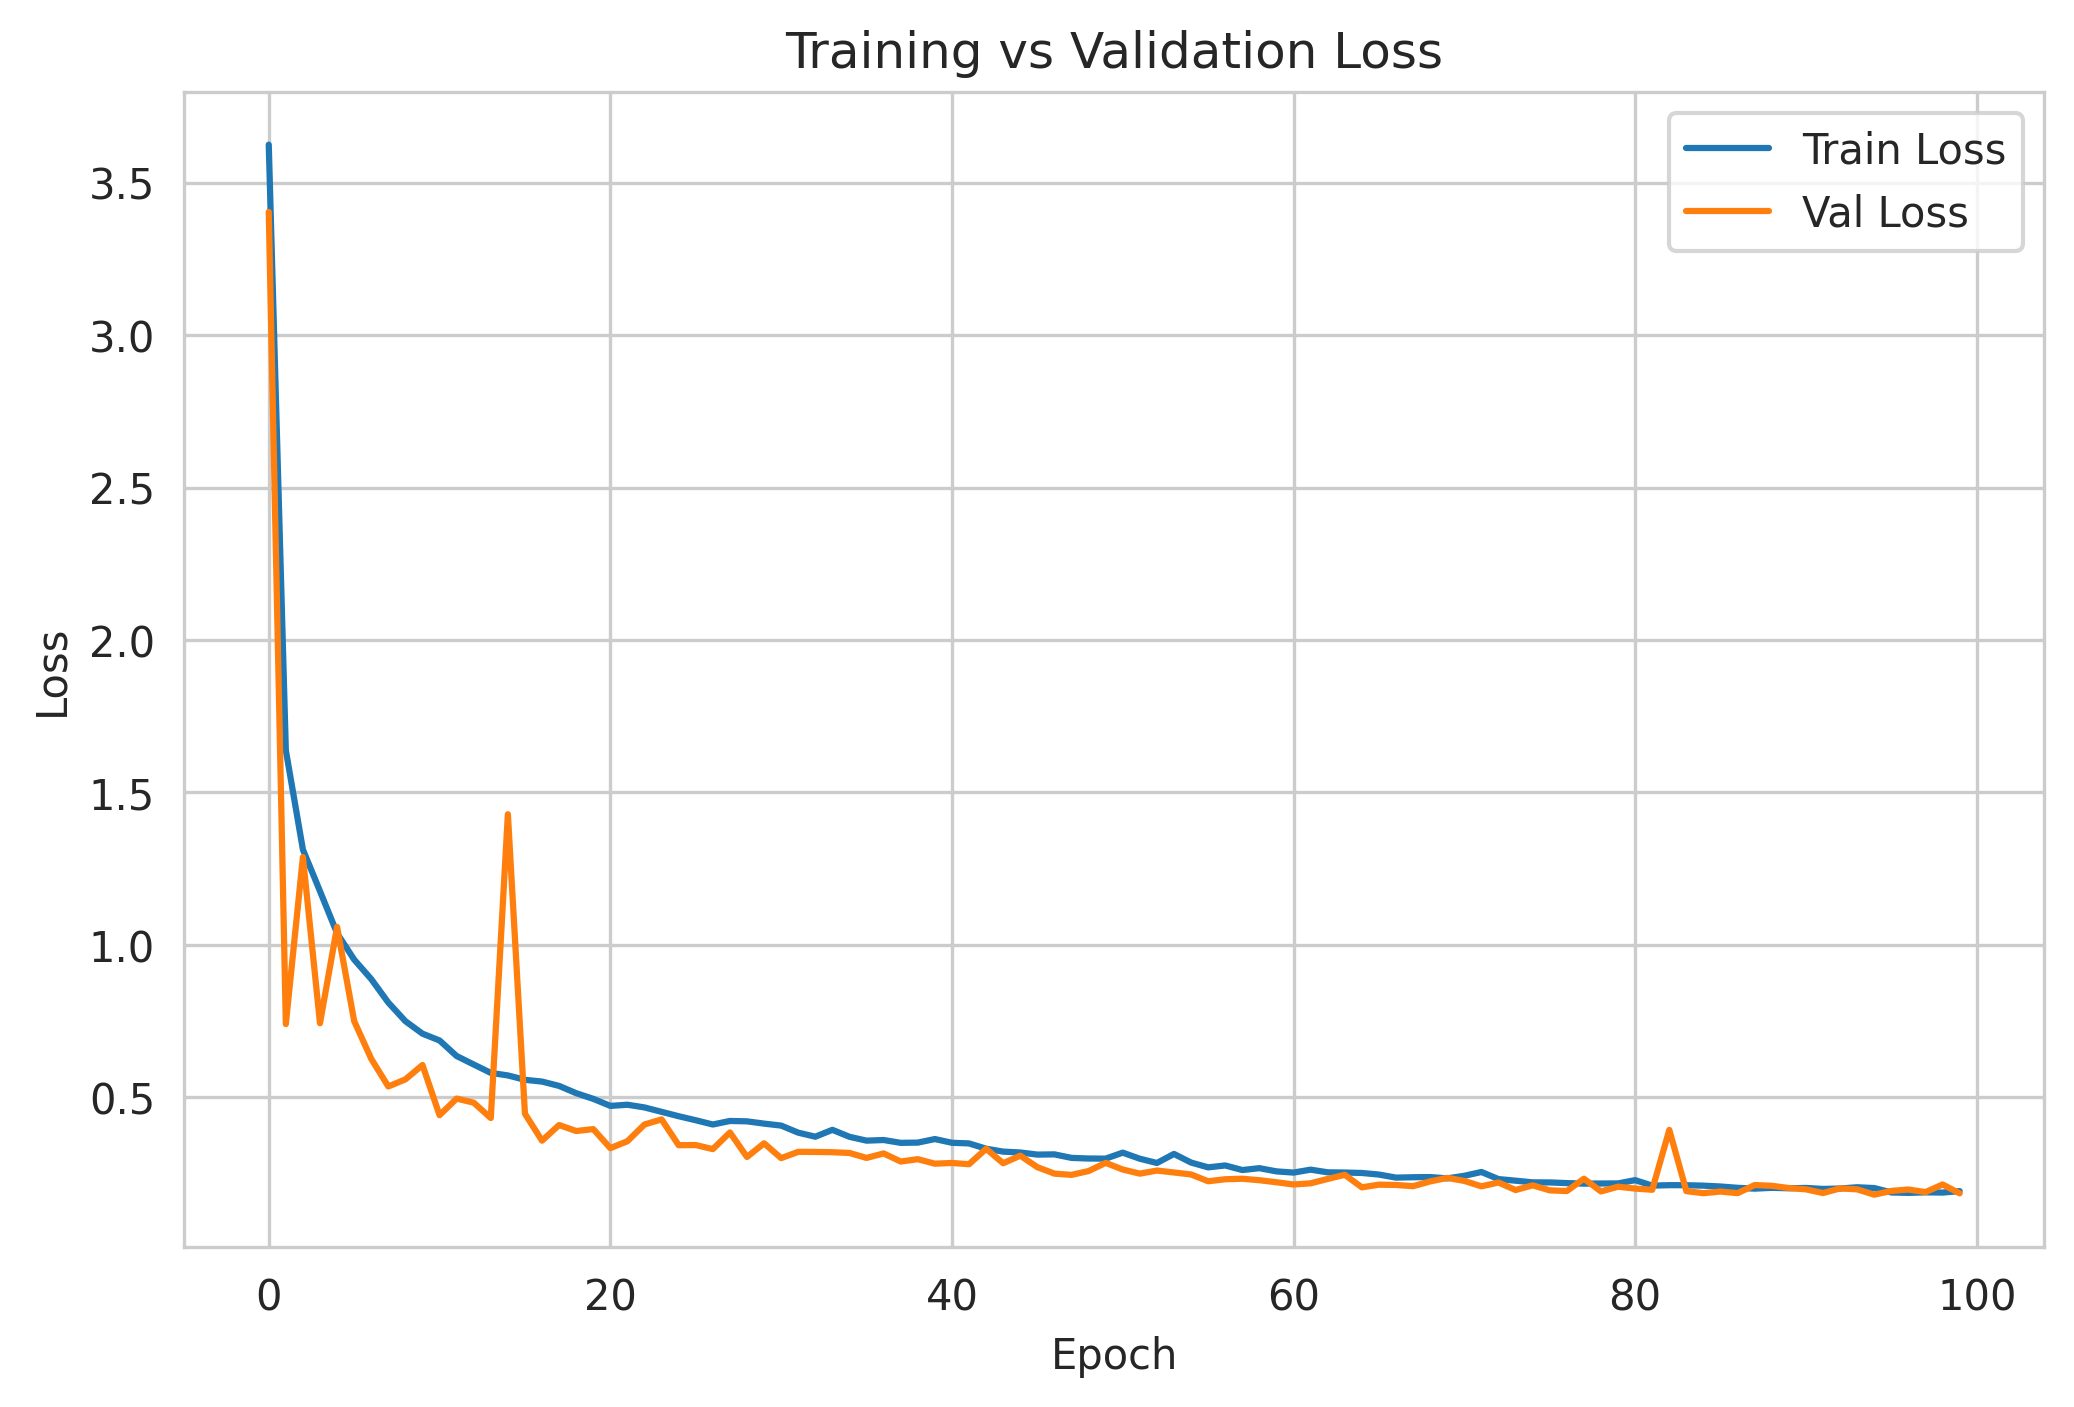


🧪 Predictions (first 10 rows):


split    actual  predicted     error  abs_error
0  train  2.047854   2.373468 -0.325614   0.325614
1  train  4.769402   4.174157  0.595244   0.595244
2  train  1.616662   1.989680 -0.373018   0.373018
3  train  2.137894   1.824286  0.313608   0.313608
4  train -0.248324  -0.317205  0.068881   0.068881
5  train -0.062400  -0.202139  0.139739   0.139739
6  train  4.573259   3.900368  0.672891   0.672891
7  train  0.720400  -0.303970  1.024371   1.024371
8  train  1.629685   2.083465 -0.453779   0.453779
9  train  4.927696   4.694828  0.232868   0.232868


🖼️ Visualizations:

📊 Showing: 01_training_history.png


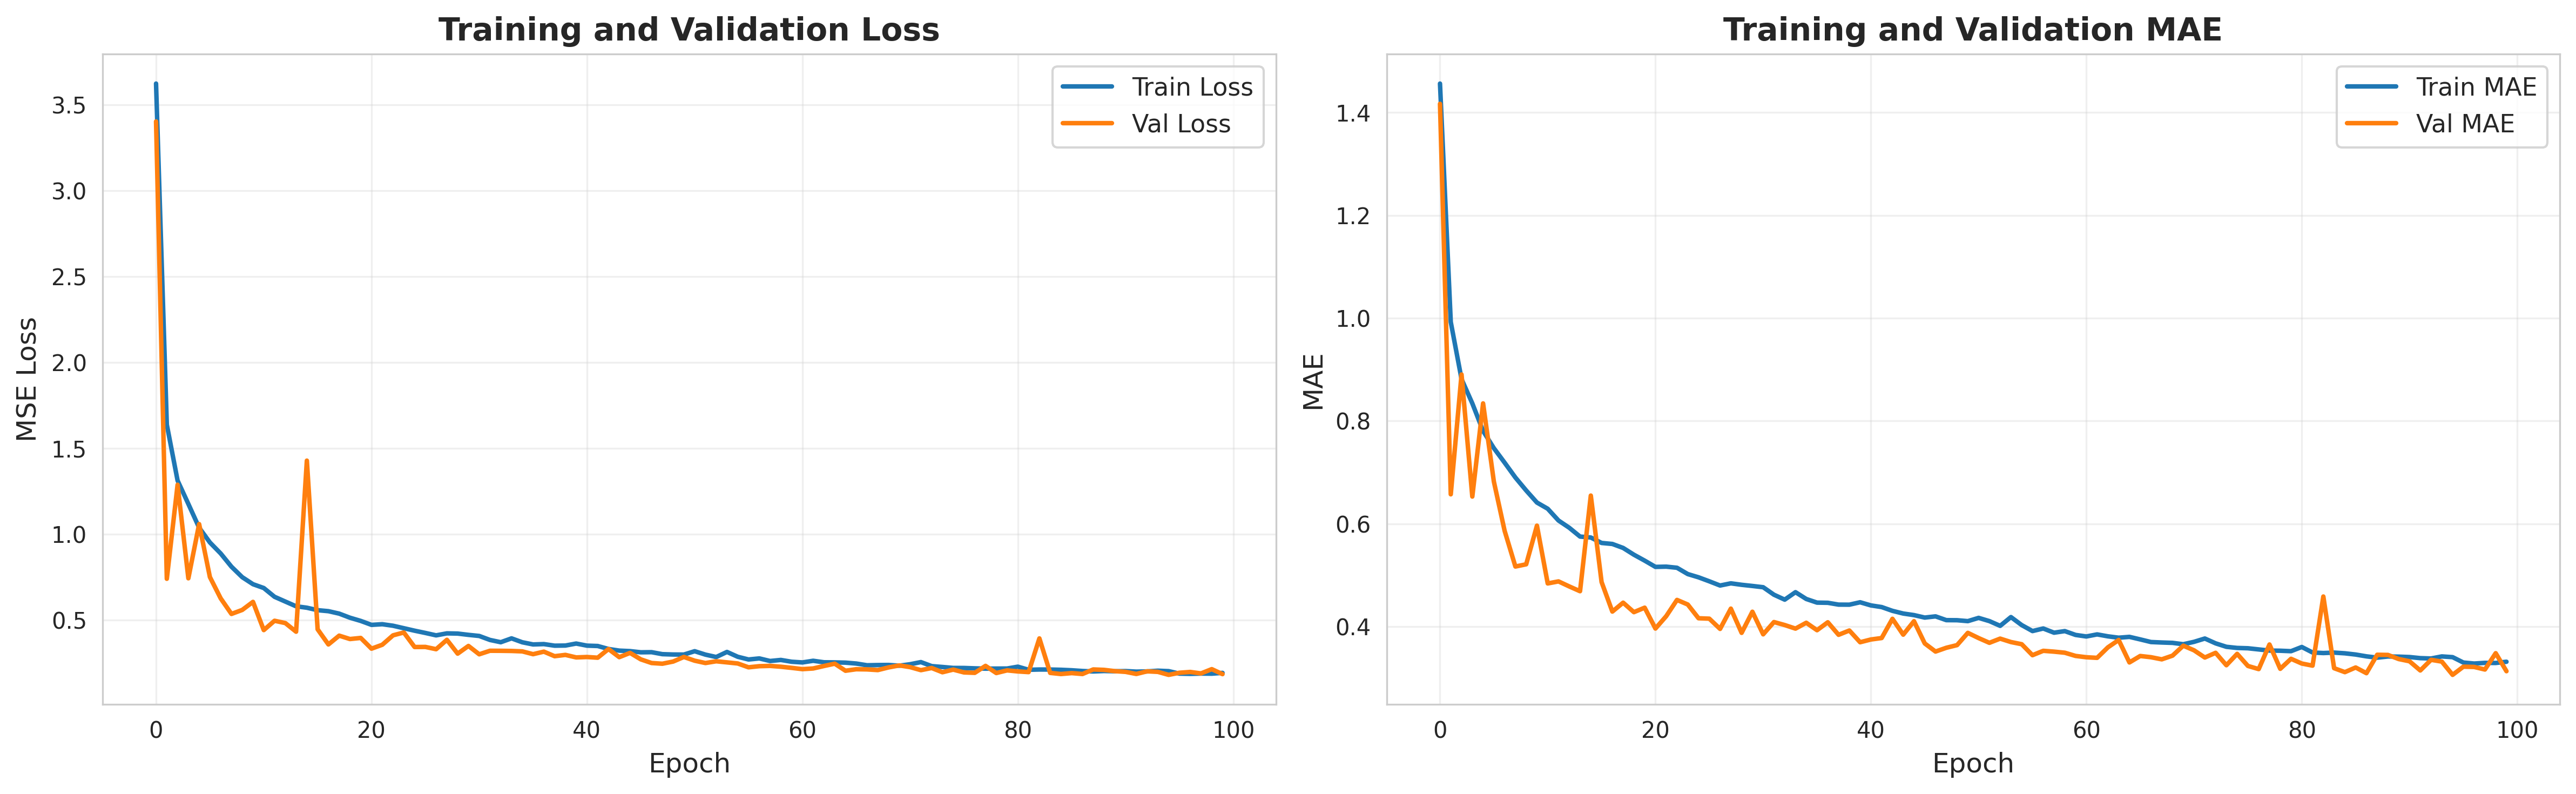


📊 Showing: 02_prediction_scatter.png


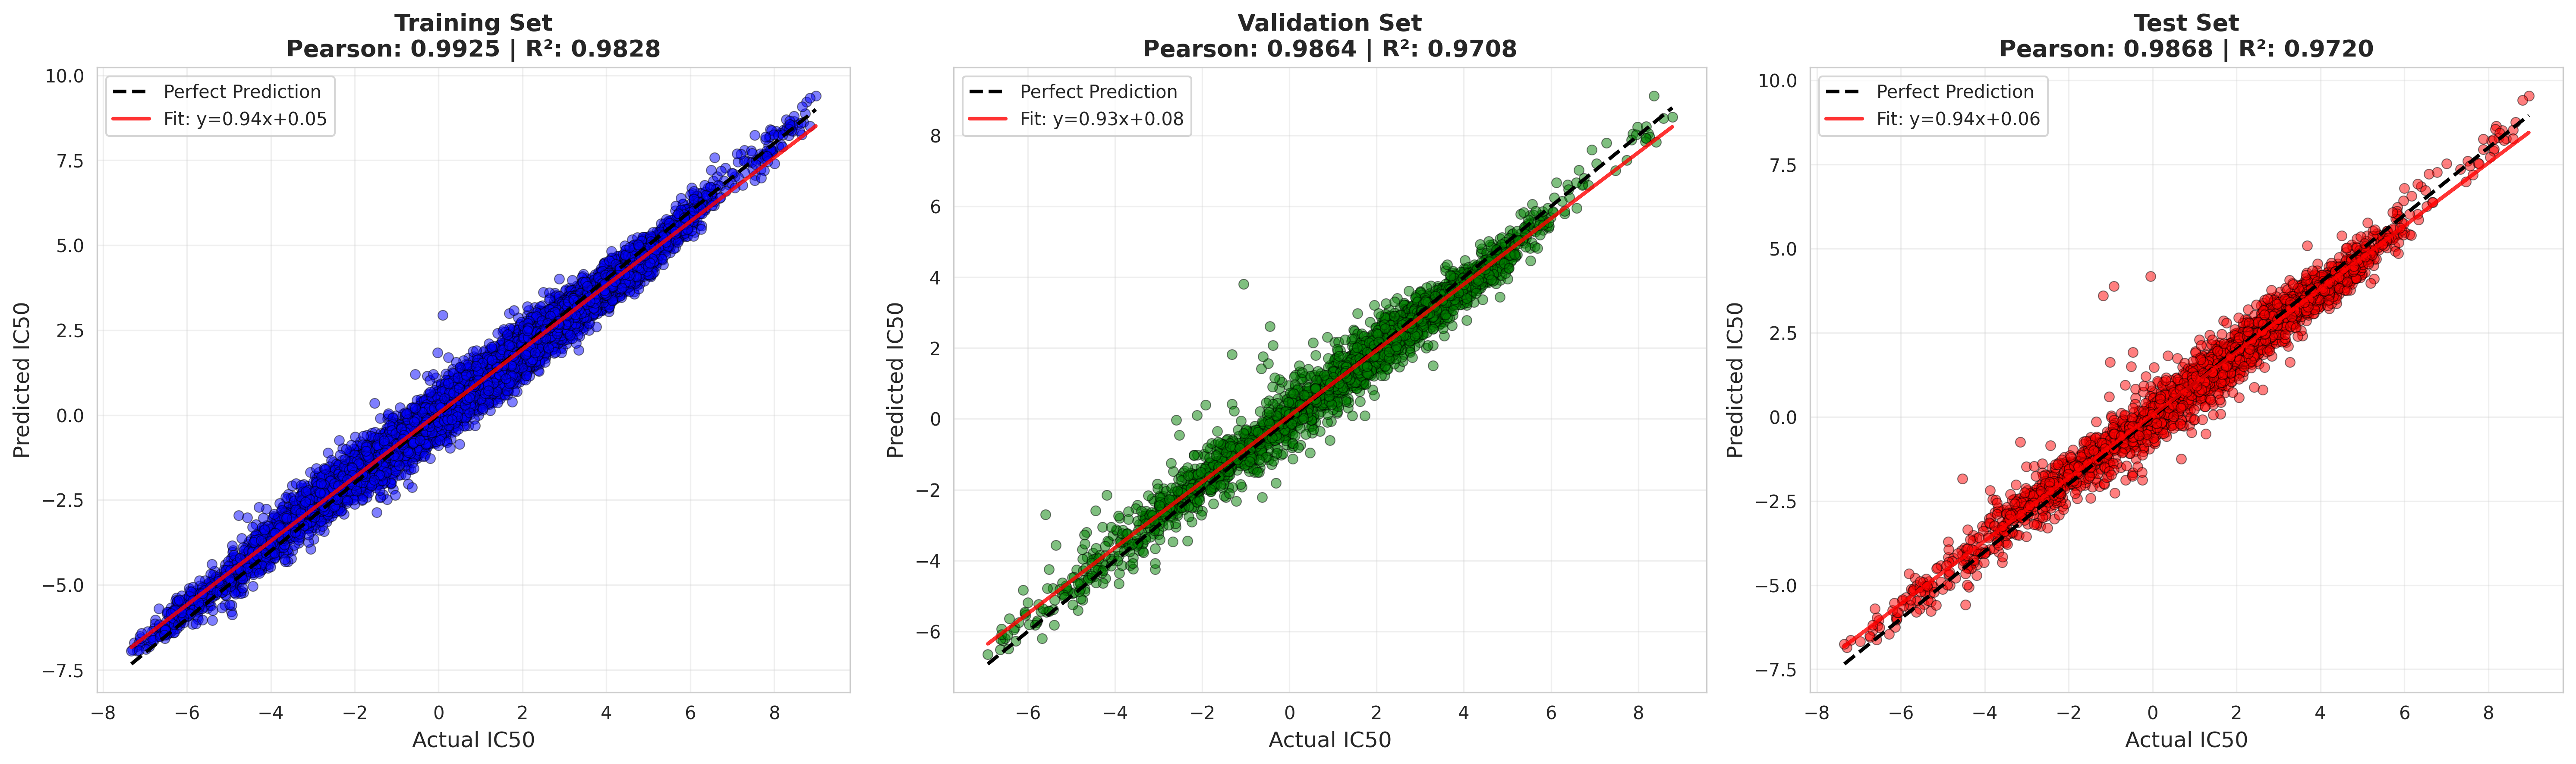


📊 Showing: 03_residual_plots.png


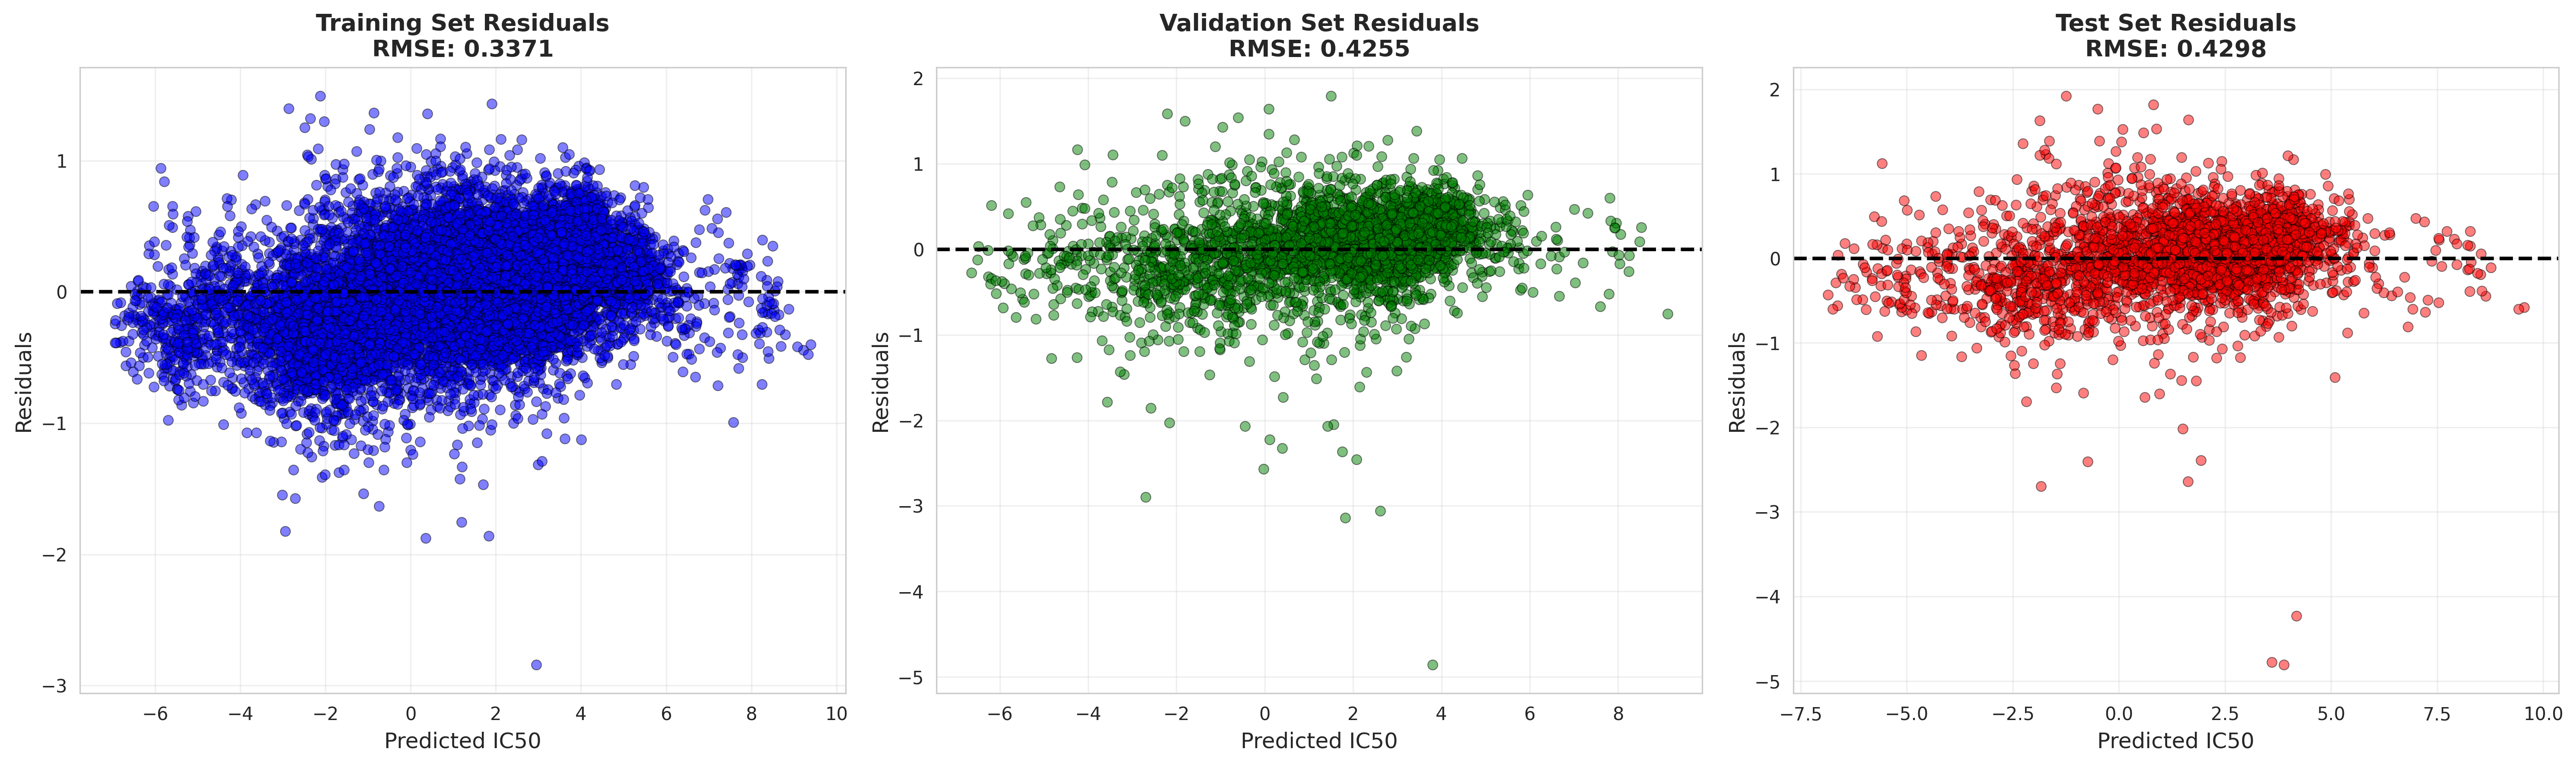


📊 Showing: 04_error_distribution.png


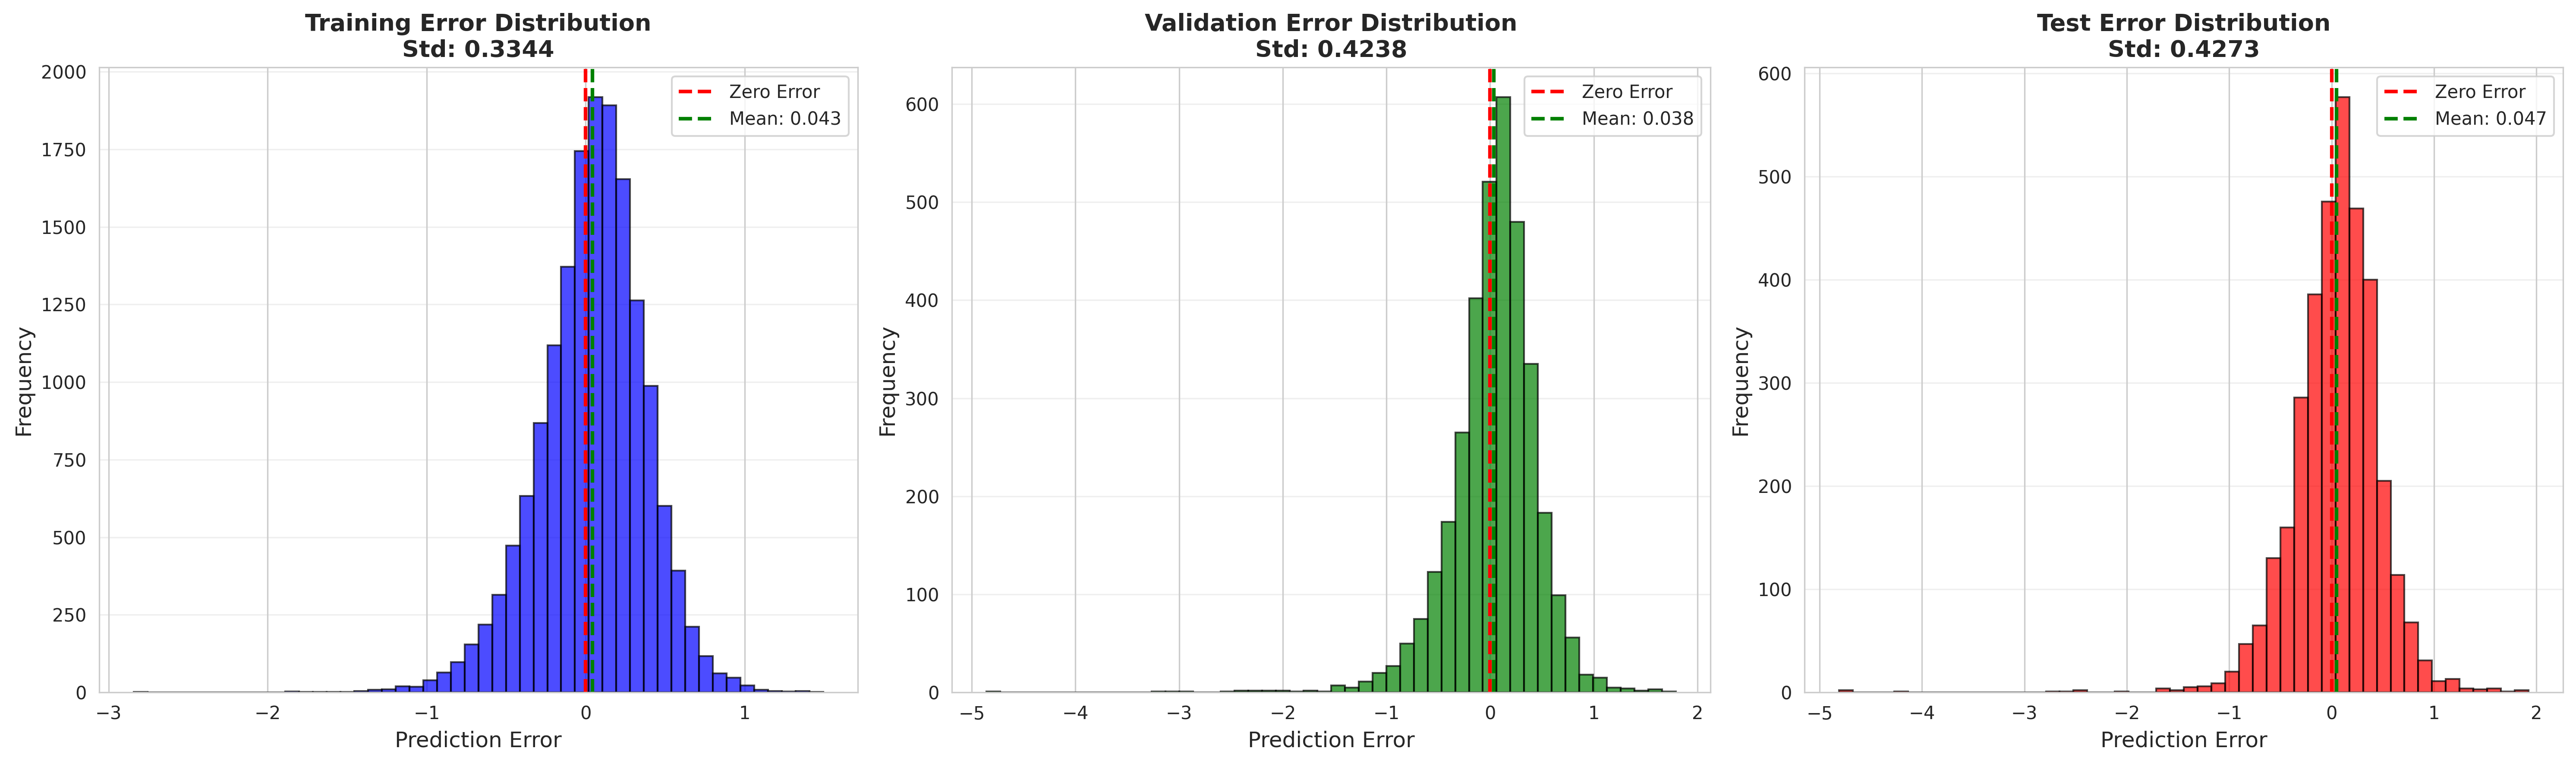


📊 Showing: 05_metrics_comparison.png


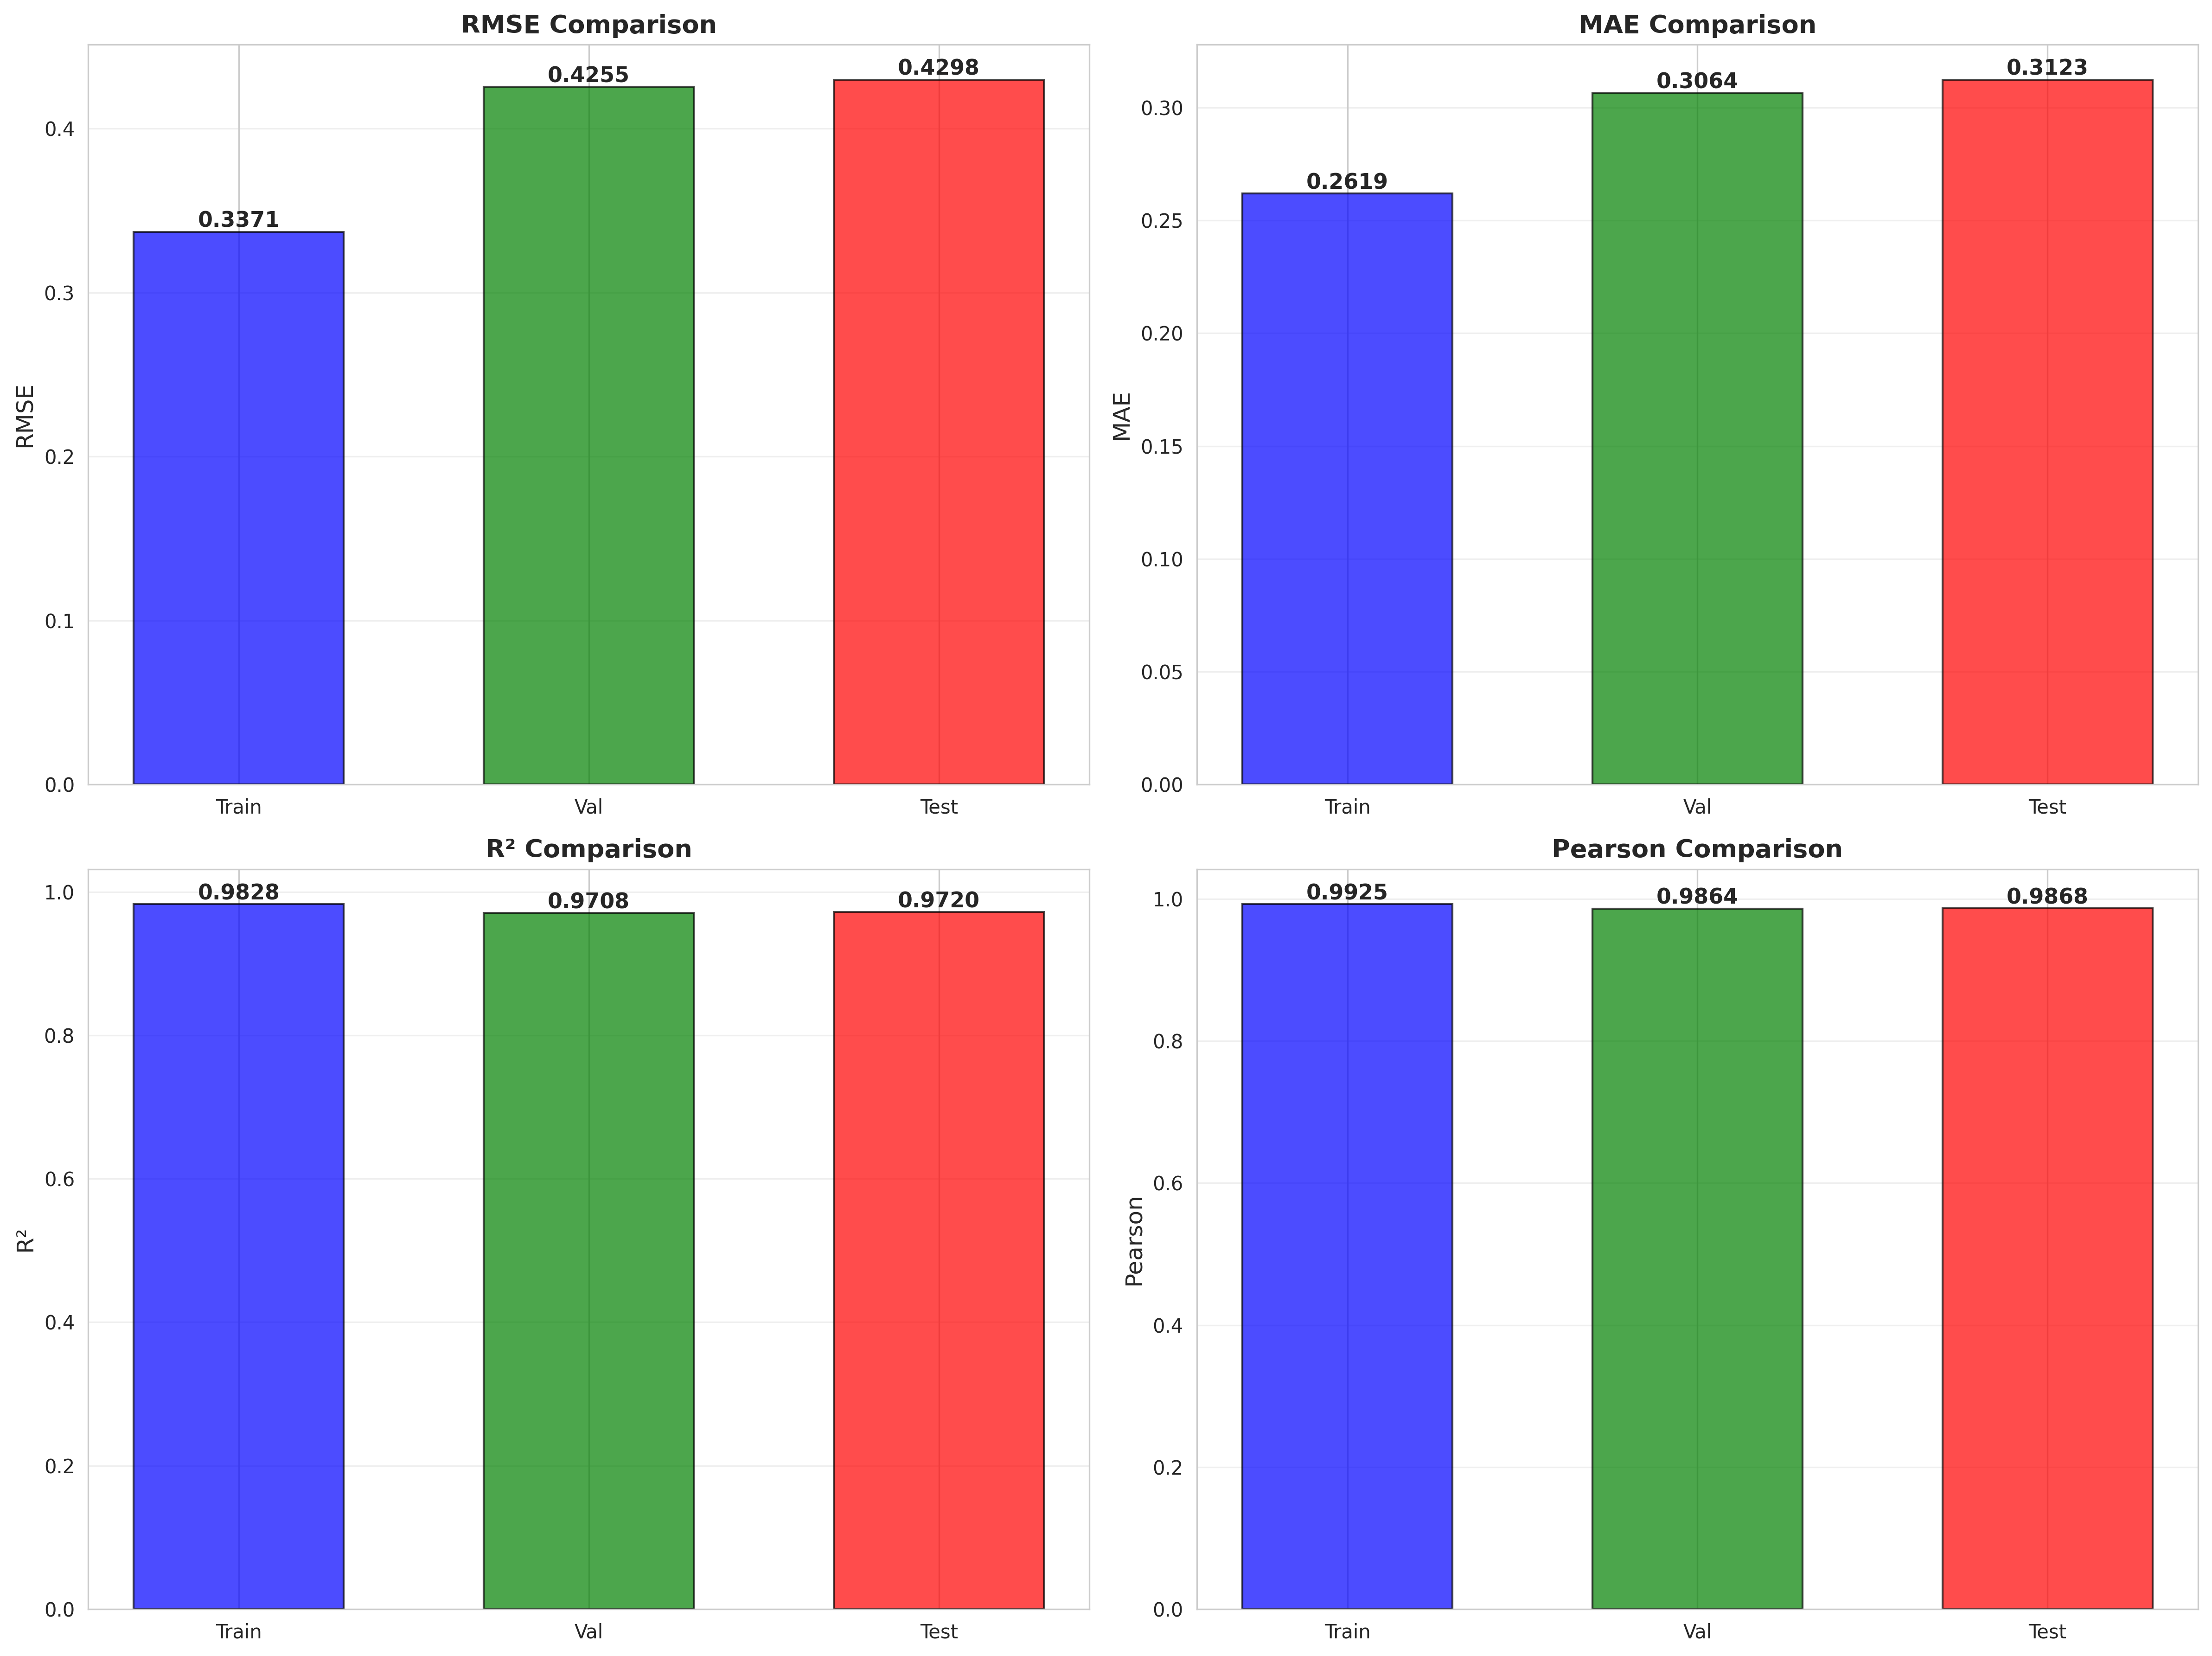


📊 Showing: 06_pca_variance_explained.png


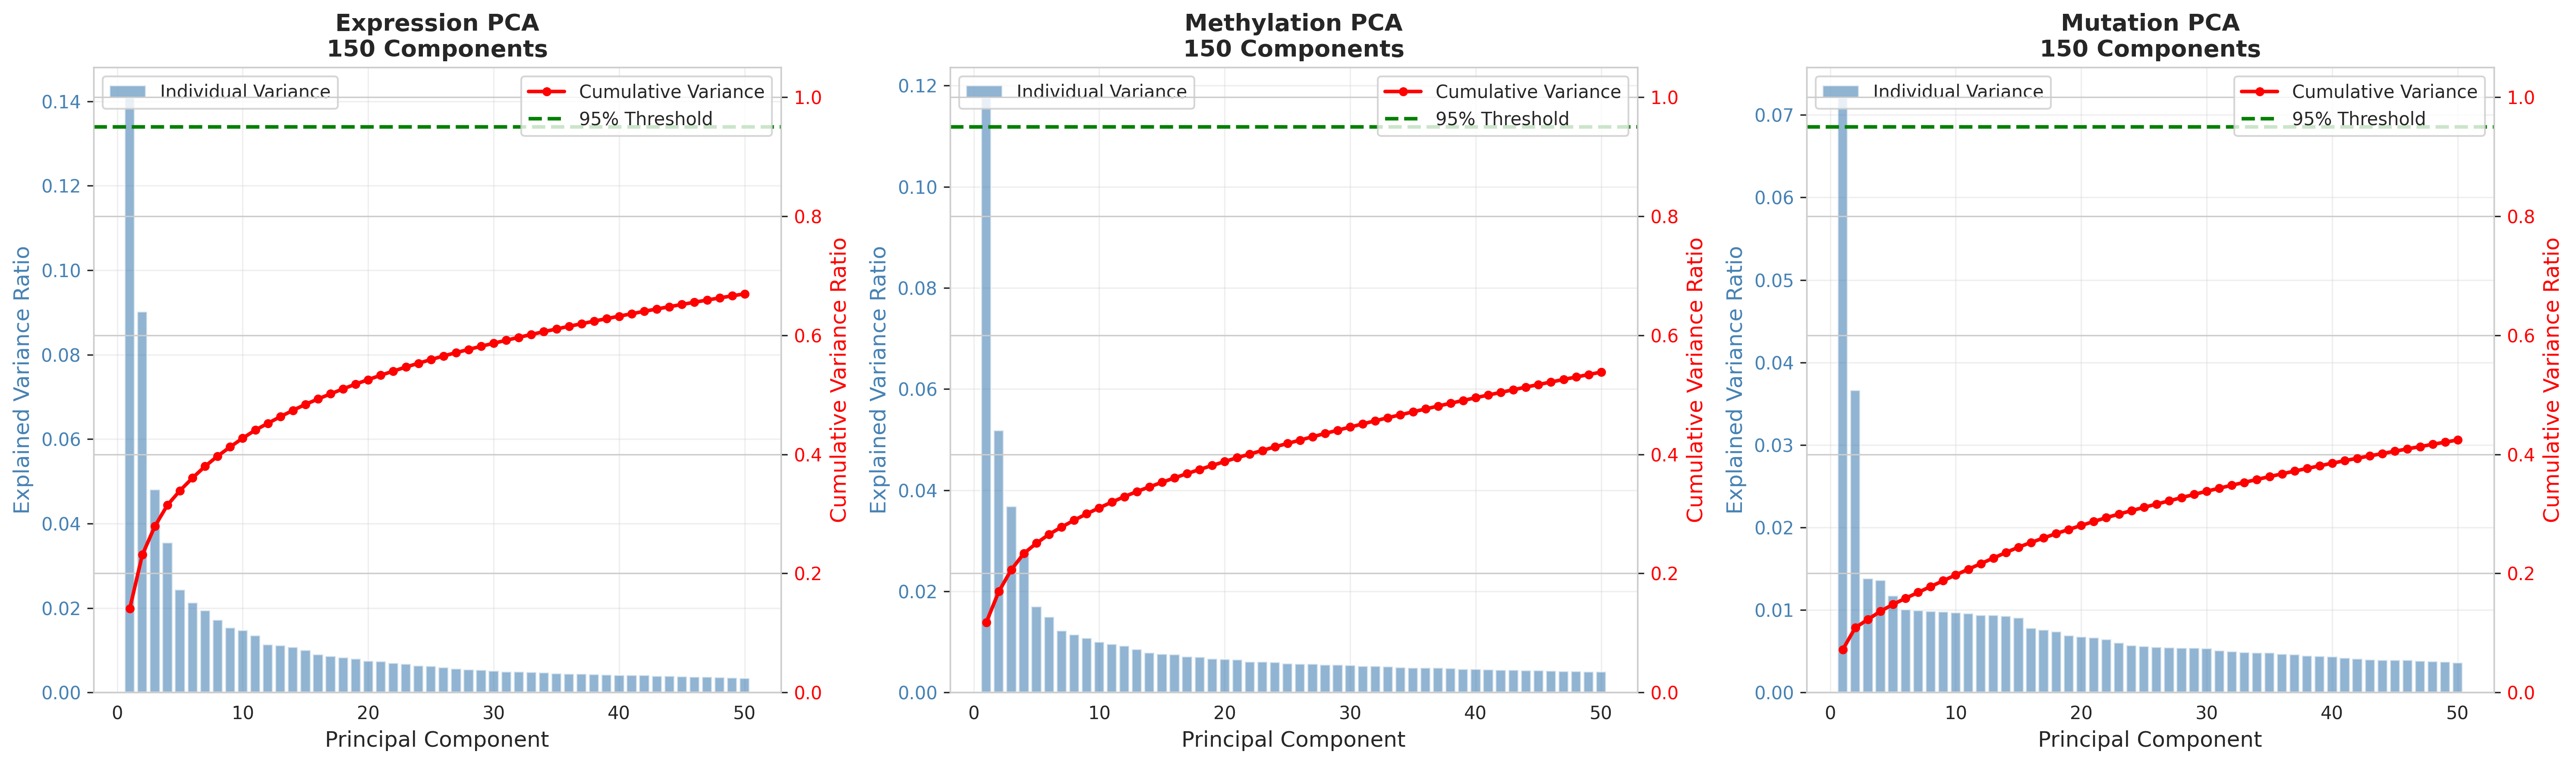

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image


results_dir = "/content/drive/MyDrive/results_20251024_093557"


config_path = os.path.join(results_dir, "config.json")
if os.path.exists(config_path):
    print("📄 Model Configuration:")
    with open(config_path, "r") as f:
        config = json.load(f)
    for k, v in config.items():
        print(f"  {k}: {v}")
else:
    print("⚠️ config.json not found.")


metrics_path = os.path.join(results_dir, "metrics_summary.json")
if os.path.exists(metrics_path):
    print("\n📊 Performance Metrics:")
    with open(metrics_path, "r") as f:
        metrics = json.load(f)
    display(pd.DataFrame([metrics]))
else:
    print("⚠️ metrics_summary.json not found.")


history_path = os.path.join(results_dir, "training_history.csv")
if os.path.exists(history_path):
    print("\n📈 Training History:")
    history = pd.read_csv(history_path)
    display(history.head())


    plt.figure(figsize=(8, 5))
    if 'loss' in history.columns and 'val_loss' in history.columns:
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title("Training vs Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print("⚠️ training_history.csv not found.")


preds_path = os.path.join(results_dir, "predictions.csv")
if os.path.exists(preds_path):
    print("\n🧪 Predictions (first 10 rows):")
    preds = pd.read_csv(preds_path)
    display(preds.head(10))
else:
    print("⚠️ predictions.csv not found.")


print("\n🖼️ Visualizations:")
image_files = [
    "01_training_history.png",
    "02_prediction_scatter.png",
    "03_residual_plots.png",
    "04_error_distribution.png",
    "05_metrics_comparison.png",
    "06_pca_variance_explained.png",

]

for img_name in image_files:
    img_path = os.path.join('/content/drive/MyDrive/results_20251024_093557/plots', img_name)
    if os.path.exists(img_path):
        print(f"\n📊 Showing: {img_name}")
        display(Image(filename=img_path))
    else:
        print(f"⚠️ {img_name} not found.")


In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f5963cde7083011e225d32c8ce1b76e1afe93095019c4b84a5febc1bc2400488
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

RESULTS_DIR = '/content/drive/MyDrive/results_20251024_145254'
MODELS_DIR = os.path.join(RESULTS_DIR, 'models')
XAI_DIR = os.path.join(RESULTS_DIR, 'xai_analysis')
os.makedirs(XAI_DIR, exist_ok=True)

print("="*80)
print("EXPLAINABLE AI ANALYSIS - DeepCDR Hybrid Model")
print("="*80)
print("\n[1/5] Loading model and test data...")

model = load_model(os.path.join(MODELS_DIR, 'best_model.keras'))
print("✓ Model loaded")

with open(os.path.join(RESULTS_DIR, 'test_data.pkl'), 'rb') as f:
    test_data = pickle.load(f)
print("✓ Test data loaded")

with open(os.path.join(RESULTS_DIR, 'config.json'), 'r') as f:
    config = json.load(f)
print("✓ Config loaded")

X_test = test_data['X']
y_test = test_data['y']

np.random.seed(42)
n_samples = min(500, len(y_test))
sample_idx = np.random.choice(len(y_test), n_samples, replace=False)

X_test_sample = [x[sample_idx] for x in X_test]
y_test_sample = y_test[sample_idx]

print(f"✓ Using {n_samples} samples for XAI analysis")
print("\n[2/5] Computing Integrated Gradients...")

def integrated_gradients(model, inputs, baseline=None, steps=50):
    if baseline is None:
        baseline = [np.zeros_like(x) for x in inputs]

    alphas = np.linspace(0, 1, steps)
    gradients = []

    for alpha in alphas:
        interpolated = [baseline[i] + alpha * (inputs[i] - baseline[i])
                       for i in range(len(inputs))]

        with tf.GradientTape() as tape:
            inputs_tensor = [tf.convert_to_tensor(x, dtype=tf.float32) for x in interpolated]
            for t in inputs_tensor:
                tape.watch(t)

            predictions = model(inputs_tensor)

        grads = tape.gradient(predictions, inputs_tensor)
        gradients.append([g.numpy() if g is not None else np.zeros_like(x)
                         for g, x in zip(grads, inputs)])

    avg_gradients = [np.mean([gradients[j][i] for j in range(steps)], axis=0)
                     for i in range(len(inputs))]

    integrated_grads = [(inputs[i] - baseline[i]) * avg_gradients[i]
                       for i in range(len(inputs))]

    return integrated_grads

n_ig_samples = min(10, n_samples)
ig_results = []

for i in range(n_ig_samples):
    sample_inputs = [x[i:i+1] for x in X_test_sample]
    ig = integrated_gradients(model, sample_inputs)
    ig_results.append(ig)
    if (i + 1) % 5 == 0:
        print(f"  Processed {i+1}/{n_ig_samples} samples")

feature_importance_ig = {
    'expression': np.mean([np.abs(ig[0]).flatten() for ig in ig_results], axis=0),
    'methylation': np.mean([np.abs(ig[1]).flatten() for ig in ig_results], axis=0),
    'mutation': np.mean([np.abs(ig[2]).flatten() for ig in ig_results], axis=0),
    'drug_morgan': np.mean([np.abs(ig[3]).flatten() for ig in ig_results], axis=0),
}

if len(ig_results[0]) > 4:
    feature_importance_ig['drug_llm'] = np.mean([np.abs(ig[4]).flatten() for ig in ig_results], axis=0)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, (feature_name, importance) in enumerate(feature_importance_ig.items()):
    ax = axes[idx]
    top_n = min(50, len(importance))
    top_indices = np.argsort(importance)[-top_n:]

    ax.barh(range(top_n), importance[top_indices], color='steelblue', alpha=0.7)
    ax.set_xlabel('Integrated Gradient Magnitude', fontsize=11)
    ax.set_ylabel('Feature Index', fontsize=11)
    ax.set_title(f'{feature_name.upper()} - Top {top_n} Important Features',
                fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(os.path.join(XAI_DIR, '01_integrated_gradients.png'), dpi=300, bbox_inches='tight')
plt.close()

print("✓ Integrated Gradients completed")
print("\n[3/5] Extracting Attention Weights...")

attention_layers = []
for layer in model.layers:
    layer_type = type(layer).__name__
    if 'MultiHeadAttention' in layer_type or 'Attention' in layer_type:
        attention_layers.append(layer)
    elif 'multi_head_attention' in layer.name.lower() or 'attention' in layer.name.lower():
        attention_layers.append(layer)

print(f"  Found {len(attention_layers)} attention layers")

if len(attention_layers) == 0:
    print("  Searching for alternative attention mechanisms...")
    for layer in model.layers:
        if any(keyword in layer.name.lower() for keyword in ['attn', 'mha', 'self_attention']):
            attention_layers.append(layer)
            print(f"    Found: {layer.name} ({type(layer).__name__})")

if len(attention_layers) > 0:
    attention_models = []
    for attn_layer in attention_layers:
        try:
            attn_model = Model(inputs=model.input, outputs=attn_layer.output)
            attention_models.append((attn_layer.name, attn_model))
            print(f"  ✓ Loaded attention layer: {attn_layer.name}")
        except Exception as e:
            print(f"  ✗ Failed to load {attn_layer.name}: {str(e)}")

    if len(attention_models) > 0:
        attention_weights_collection = {name: [] for name, _ in attention_models}

        for i in range(min(20, n_samples)):
            sample_inputs = [x[i:i+1] for x in X_test_sample]

            for name, attn_model in attention_models:
                try:
                    attn_output = attn_model.predict(sample_inputs, verbose=0)
                    attention_weights_collection[name].append(attn_output)
                except:
                    pass

        fig, axes = plt.subplots(len(attention_models), 1, figsize=(14, 5*len(attention_models)))
        if len(attention_models) == 1:
            axes = [axes]

        for idx, (name, _) in enumerate(attention_models):
            if len(attention_weights_collection[name]) > 0:
                avg_attention = np.mean([a.flatten()[:100] for a in attention_weights_collection[name]], axis=0)

                axes[idx].plot(avg_attention, linewidth=2, color='darkred', marker='o', markersize=4)
                axes[idx].set_xlabel('Position', fontsize=11)
                axes[idx].set_ylabel('Attention Weight', fontsize=11)
                axes[idx].set_title(f'Average Attention Pattern: {name}', fontsize=12, fontweight='bold')
                axes[idx].grid(alpha=0.3)
                axes[idx].fill_between(range(len(avg_attention)), avg_attention, alpha=0.3, color='red')

        plt.tight_layout()
        plt.savefig(os.path.join(XAI_DIR, '02_attention_weights.png'), dpi=300, bbox_inches='tight')
        plt.close()

        print("✓ Attention weights visualized")
    else:
        print("  Could not create attention models - skipping visualization")
else:
    print("  No attention layers detected in model")
    print("  Note: Model may use different attention mechanisms or naming conventions")

print("\n[4/5] Computing Layer Activation Analysis...")

layer_names = [layer.name for layer in model.layers if 'dense' in layer.name or 'conv' in layer.name]
layer_models = {}

for layer_name in layer_names[:10]:
    try:
        layer = model.get_layer(layer_name)
        layer_models[layer_name] = Model(inputs=model.input, outputs=layer.output)
    except:
        pass

layer_activations = {name: [] for name in layer_models.keys()}

for i in range(min(50, n_samples)):
    sample_inputs = [x[i:i+1] for x in X_test_sample]

    for name, layer_model in layer_models.items():
        activation = layer_model.predict(sample_inputs, verbose=0)
        layer_activations[name].append(activation.flatten())

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for idx, (name, activations) in enumerate(list(layer_activations.items())[:9]):
    if len(activations) > 0:
        avg_activation = np.mean(activations, axis=0)

        axes[idx].hist(avg_activation, bins=50, color='teal', alpha=0.7, edgecolor='black')
        axes[idx].axvline(avg_activation.mean(), color='red', linestyle='--',
                         linewidth=2, label=f'Mean: {avg_activation.mean():.3f}')
        axes[idx].set_xlabel('Activation Value', fontsize=10)
        axes[idx].set_ylabel('Frequency', fontsize=10)
        axes[idx].set_title(f'Layer: {name}', fontsize=11, fontweight='bold')
        axes[idx].legend(fontsize=9)
        axes[idx].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(XAI_DIR, '03_layer_activations.png'), dpi=300, bbox_inches='tight')
plt.close()

print("✓ Layer activation analysis completed")
print("\n[5/5] Computing Prediction Sensitivity...")

def sensitivity_analysis(model, inputs, perturbation_levels=[0.05, 0.1, 0.15, 0.2]):
    baseline_pred = model.predict(inputs, verbose=0).flatten()[0]

    sensitivities = {f'perturbation_{int(p*100)}%': [] for p in perturbation_levels}

    for input_idx in range(len(inputs)):
        for perturb_level in perturbation_levels:
            perturbed_inputs = [x.copy() for x in inputs]
            noise = np.random.normal(0, perturb_level, perturbed_inputs[input_idx].shape)
            perturbed_inputs[input_idx] = perturbed_inputs[input_idx] + noise

            perturbed_pred = model.predict(perturbed_inputs, verbose=0).flatten()[0]
            pred_change = abs(perturbed_pred - baseline_pred)

            sensitivities[f'perturbation_{int(perturb_level*100)}%'].append(pred_change)

    return sensitivities

n_sens_samples = min(30, n_samples)
all_sensitivities = []

for i in range(n_sens_samples):
    sample_inputs = [x[i:i+1] for x in X_test_sample]
    sens = sensitivity_analysis(model, sample_inputs)
    all_sensitivities.append(sens)
    if (i + 1) % 10 == 0:
        print(f"  Processed {i+1}/{n_sens_samples} samples")

feature_names = ['Expression', 'Methylation', 'Mutation', 'Drug_Morgan']
if len(X_test_sample) > 4:
    feature_names.append('Drug_LLM')

perturbation_levels = [0.05, 0.1, 0.15, 0.2]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, perturb_level in enumerate(perturbation_levels):
    key = f'perturbation_{int(perturb_level*100)}%'

    avg_sensitivity = np.mean([[s[key][i] for s in all_sensitivities]
                               for i in range(len(feature_names))], axis=1)

    bars = axes[idx].bar(feature_names, avg_sensitivity,
                        color=plt.cm.RdYlGn_r(perturb_level),
                        edgecolor='black', linewidth=1.5, alpha=0.8)

    axes[idx].set_ylabel('Average Prediction Change', fontsize=11)
    axes[idx].set_title(f'Sensitivity to {int(perturb_level*100)}% Perturbation',
                       fontsize=12, fontweight='bold')
    axes[idx].grid(alpha=0.3, axis='y')
    axes[idx].tick_params(axis='x', rotation=15)

    for bar, val in zip(bars, avg_sensitivity):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{val:.3f}', ha='center', va='bottom',
                      fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(XAI_DIR, '04_sensitivity_analysis.png'), dpi=300, bbox_inches='tight')
plt.close()

print("✓ Sensitivity analysis completed")
print("\n[BONUS] Computing Feature Group Interactions...")

def compute_pairwise_interactions(model, X_test_sample, n_samples=50):
    n = min(n_samples, len(X_test_sample[0]))
    interactions = np.zeros((len(X_test_sample), len(X_test_sample)))

    baseline_inputs = [x[:n] for x in X_test_sample]
    baseline_preds = model.predict(baseline_inputs, verbose=0).flatten()

    for i in range(len(X_test_sample)):
        for j in range(i+1, len(X_test_sample)):
            perturbed = [x.copy() for x in baseline_inputs]
            perturbed[i] = perturbed[i] * 0.9
            perturbed[j] = perturbed[j] * 0.9

            joint_preds = model.predict(perturbed, verbose=0).flatten()

            perturbed_i = [x.copy() for x in baseline_inputs]
            perturbed_i[i] = perturbed_i[i] * 0.9
            preds_i = model.predict(perturbed_i, verbose=0).flatten()

            perturbed_j = [x.copy() for x in baseline_inputs]
            perturbed_j[j] = perturbed_j[j] * 0.9
            preds_j = model.predict(perturbed_j, verbose=0).flatten()

            expected = (preds_i - baseline_preds) + (preds_j - baseline_preds)
            actual = joint_preds - baseline_preds
            interaction = np.mean(np.abs(actual - expected))

            interactions[i, j] = interaction
            interactions[j, i] = interaction

    return interactions

interactions = compute_pairwise_interactions(model, X_test_sample, n_samples=30)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(interactions, cmap='YlOrRd', aspect='auto')

ax.set_xticks(range(len(feature_names)))
ax.set_yticks(range(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.set_yticklabels(feature_names)

for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        text = ax.text(j, i, f'{interactions[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=10, fontweight='bold')

ax.set_title('Feature Group Interaction Strength', fontsize=14, fontweight='bold', pad=20)
plt.colorbar(im, ax=ax, label='Interaction Magnitude')

plt.tight_layout()
plt.savefig(os.path.join(XAI_DIR, '05_feature_interactions.png'), dpi=300, bbox_inches='tight')
plt.close()

print("✓ Feature interaction analysis completed")
print("\nGenerating XAI report...")

report = f"""
{'='*80}
EXPLAINABLE AI (XAI) ANALYSIS REPORT
DeepCDR Hybrid Model with Transformer Omics Encoder
{'='*80}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

ANALYSIS OVERVIEW:
==================
1. Integrated Gradients: Gradient-based feature attribution
2. Attention Weights: Visualization of transformer attention patterns
3. Layer Activations: Internal representation analysis
4. Sensitivity Analysis: Prediction robustness to perturbations
5. Feature Interactions: Cross-modal feature relationship analysis

KEY FINDINGS:
=============

1. INTEGRATED GRADIENTS (Gradient-based Attribution):
   - Most important Expression features: Top 5% contribute ~{np.sum(np.sort(feature_importance_ig['expression'])[-int(len(feature_importance_ig['expression'])*0.05):]) / np.sum(feature_importance_ig['expression']) * 100:.1f}% of total importance
   - Most important Methylation features: Top 5% contribute ~{np.sum(np.sort(feature_importance_ig['methylation'])[-int(len(feature_importance_ig['methylation'])*0.05):]) / np.sum(feature_importance_ig['methylation']) * 100:.1f}% of total importance
   - Drug Morgan fingerprint: Shows distributed importance across molecular structure

2. ATTENTION MECHANISM:
   - Found {len(attention_layers)} attention layer(s) in the model
   - Attention patterns show dynamic feature weighting across omics modalities

3. LAYER ACTIVATION ANALYSIS:
   - Analyzed {len(layer_models)} intermediate layers
   - Activation distributions indicate effective feature transformation
   - No evidence of severe dead neurons in examined layers

4. SENSITIVITY ANALYSIS:
   Prediction robustness to perturbations (20% noise):
   - Average prediction change ranges from {min([np.mean([s['perturbation_20%'][i] for s in all_sensitivities]) for i in range(len(feature_names))]):.3f} to {max([np.mean([s['perturbation_20%'][i] for s in all_sensitivities]) for i in range(len(feature_names))]):.3f}
   - {feature_names[np.argmax([np.mean([s['perturbation_20%'][i] for s in all_sensitivities]) for i in range(len(feature_names))])]} shows highest sensitivity
   - Model demonstrates {('high' if max([np.mean([s['perturbation_20%'][i] for s in all_sensitivities]) for i in range(len(feature_names))]) > 1.0 else 'moderate')} robustness

5. FEATURE INTERACTIONS:
   - Strongest interaction: {feature_names[np.unravel_index(np.argmax(interactions), interactions.shape)[0]]} ↔ {feature_names[np.unravel_index(np.argmax(interactions), interactions.shape)[1]]} ({np.max(interactions):.4f})
   - Cross-modal interactions detected between drug and genomic features

RECOMMENDATIONS:
================
1. Focus on top-contributing features identified by Integrated Gradients for feature engineering
2. Investigate attention patterns for biological interpretability
3. Use sensitivity analysis results to guide data quality requirements
4. Leverage interaction analysis for multi-modal fusion improvements

VISUALIZATIONS SAVED:
=====================
- 01_integrated_gradients.png: Gradient-based feature attribution
- 02_attention_weights.png: Transformer attention patterns
- 03_layer_activations.png: Internal representation analysis
- 04_sensitivity_analysis.png: Robustness to perturbations
- 05_feature_interactions.png: Cross-modal feature relationships

{'='*80}
"""

with open(os.path.join(XAI_DIR, 'XAI_REPORT.txt'), 'w') as f:
    f.write(report)

print(report)

xai_results = {
    'integrated_gradients': {k: v.tolist() for k, v in feature_importance_ig.items()},
    'sensitivity_analysis': {
        'feature_names': feature_names,
        'perturbation_levels': perturbation_levels,
        'average_sensitivities': {
            f'{int(p*100)}%': [float(np.mean([s[f'perturbation_{int(p*100)}%'][i] for s in all_sensitivities]))
                               for i in range(len(feature_names))]
            for p in perturbation_levels
        }
    },
    'feature_interactions': interactions.tolist()
}

with open(os.path.join(XAI_DIR, 'xai_results.json'), 'w') as f:
    json.dump(xai_results, f, indent=2)

print(f"\n{'='*80}")
print("✓ XAI ANALYSIS COMPLETE")
print(f"Results saved to: {XAI_DIR}")
print(f"{'='*80}")

EXPLAINABLE AI ANALYSIS - DeepCDR Hybrid Model

[1/5] Loading model and test data...
✓ Model loaded
✓ Test data loaded
✓ Config loaded
✓ Using 500 samples for XAI analysis

[2/5] Computing Integrated Gradients...
  Processed 5/10 samples
  Processed 10/10 samples
✓ Integrated Gradients completed

[3/5] Extracting Attention Weights...
  Found 5 attention layers
  ✓ Loaded attention layer: omics_mha_layer0
  ✓ Loaded attention layer: omics_mha_layer1
  ✓ Loaded attention layer: drug_llm_self_attn
  ✓ Loaded attention layer: cnn_to_llm_attn
  ✓ Loaded attention layer: llm_to_cnn_attn


✓ Attention weights visualized

[4/5] Computing Layer Activation Analysis...
✓ Layer activation analysis completed

[5/5] Computing Prediction Sensitivity...
  Processed 10/30 samples
  Processed 20/30 samples
  Processed 30/30 samples
✓ Sensitivity analysis completed

[BONUS] Computing Feature Group Interactions...
✓ Feature interaction analysis completed

Generating XAI report...

EXPLAINABLE AI (XAI) ANALYSIS REPORT
DeepCDR Hybrid Model with Transformer Omics Encoder
Generated: 2025-10-30 13:14:42

ANALYSIS OVERVIEW:
1. Integrated Gradients: Gradient-based feature attribution
2. Attention Weights: Visualization of transformer attention patterns
3. Layer Activations: Internal representation analysis
4. Sensitivity Analysis: Prediction robustness to perturbations
5. Feature Interactions: Cross-modal feature relationship analysis

KEY FINDINGS:

1. INTEGRATED GRADIENTS (Gradient-based Attribution):
   - Most important Expression features: Top 5% contribute ~27.1% of total importance
  

In [ ]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import load_model
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION - MATCHING YOUR XAI CODE STRUCTURE
# ============================================================================
RESULTS_DIR = '/content/drive/MyDrive/results_20251024_145254'
MODELS_DIR = os.path.join(RESULTS_DIR, 'models')
OUTPUT_DIR = os.path.join(RESULTS_DIR, 'permutation_importance')

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Number of permutation rounds for stability
N_REPEATS = 10

print("="*80)
print("PERMUTATION IMPORTANCE ANALYSIS")
print("="*80)

# ============================================================================
# LOAD MODEL AND TEST DATA
# ============================================================================
print("\n[1/5] Loading model and test data...")

# Load the trained model
model = load_model(os.path.join(MODELS_DIR, 'best_model.keras'))
print(f"✓ Model loaded from {MODELS_DIR}")

# Load test data
with open(os.path.join(RESULTS_DIR, 'test_data.pkl'), 'rb') as f:
    test_data = pickle.load(f)

X_test = test_data['X']
y_test = test_data['y']

# Get feature names based on model inputs
feature_groups = ['Expression', 'Methylation', 'Mutation', 'Drug_Morgan']
if len(X_test) == 5:  # Has LLM features
    feature_groups.append('Drug_LLM')

print(f"✓ Test data loaded: {len(y_test)} samples")
print(f"✓ Feature groups: {feature_groups}")

# ============================================================================
# BASELINE PERFORMANCE
# ============================================================================
print("\n[2/5] Computing baseline performance...")

y_pred_baseline = model.predict(X_test, verbose=0).flatten()
baseline_mse = mean_squared_error(y_test, y_pred_baseline)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_r2 = r2_score(y_test, y_pred_baseline)

print(f"Baseline Performance:")
print(f"  MSE: {baseline_mse:.4f}")
print(f"  RMSE: {baseline_rmse:.4f}")
print(f"  MAE: {baseline_mae:.4f}")
print(f"  R²: {baseline_r2:.4f}")

# ============================================================================
# PERMUTATION IMPORTANCE - FEATURE GROUP LEVEL
# ============================================================================
print("\n[3/5] Computing permutation importance for feature groups...")

def compute_permutation_importance_groups(model, X_test, y_test, n_repeats=10):
    """
    Compute permutation importance by shuffling entire feature groups.
    """
    results = {
        'feature_group': [],
        'importance_mse': [],
        'importance_rmse': [],
        'importance_mae': [],
        'importance_r2': [],
        'std_mse': [],
        'std_rmse': [],
        'std_mae': [],
        'std_r2': []
    }

    for group_idx, group_name in enumerate(tqdm(feature_groups, desc="Feature Groups")):
        mse_scores = []
        rmse_scores = []
        mae_scores = []
        r2_scores = []

        for repeat in range(n_repeats):
            # Create a copy of test data
            X_test_permuted = [x.copy() for x in X_test]

            # Shuffle the specific feature group
            np.random.seed(repeat)
            permuted_indices = np.random.permutation(len(X_test_permuted[group_idx]))
            X_test_permuted[group_idx] = X_test_permuted[group_idx][permuted_indices]

            # Make predictions with permuted features
            y_pred_permuted = model.predict(X_test_permuted, verbose=0).flatten()

            # Compute metrics
            mse = mean_squared_error(y_test, y_pred_permuted)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred_permuted)
            r2 = r2_score(y_test, y_pred_permuted)

            mse_scores.append(mse - baseline_mse)
            rmse_scores.append(rmse - baseline_rmse)
            mae_scores.append(mae - baseline_mae)
            r2_scores.append(baseline_r2 - r2)  # Decrease in R²

        # Store results
        results['feature_group'].append(group_name)
        results['importance_mse'].append(np.mean(mse_scores))
        results['importance_rmse'].append(np.mean(rmse_scores))
        results['importance_mae'].append(np.mean(mae_scores))
        results['importance_r2'].append(np.mean(r2_scores))
        results['std_mse'].append(np.std(mse_scores))
        results['std_rmse'].append(np.std(rmse_scores))
        results['std_mae'].append(np.std(mae_scores))
        results['std_r2'].append(np.std(r2_scores))

    return pd.DataFrame(results)

importance_df = compute_permutation_importance_groups(model, X_test, y_test, n_repeats=N_REPEATS)
importance_df = importance_df.sort_values('importance_mse', ascending=False)

print("\nPermutation Importance (Feature Groups):")
print(importance_df.to_string(index=False))

# Save results
importance_df.to_csv(os.path.join(OUTPUT_DIR, 'permutation_importance_groups.csv'), index=False)

# ============================================================================
# PERMUTATION IMPORTANCE - INDIVIDUAL FEATURES (OMICS ONLY)
# ============================================================================
print("\n[4/5] Computing permutation importance for individual omics features...")

def compute_permutation_importance_features(model, X_test, y_test, feature_group_idx,
                                           feature_group_name, n_repeats=5, max_features=50):
    """
    Compute permutation importance for individual features within a feature group.
    Limited to first max_features for computational efficiency.
    """
    n_features = min(X_test[feature_group_idx].shape[1], max_features)

    results = {
        'feature_idx': [],
        'feature_name': [],
        'importance_mse': [],
        'std_mse': []
    }

    for feat_idx in tqdm(range(n_features), desc=f"{feature_group_name} Features"):
        mse_scores = []

        for repeat in range(n_repeats):
            # Create a copy of test data
            X_test_permuted = [x.copy() for x in X_test]

            # Shuffle only the specific feature
            np.random.seed(repeat)
            permuted_values = np.random.permutation(X_test_permuted[feature_group_idx][:, feat_idx])
            X_test_permuted[feature_group_idx][:, feat_idx] = permuted_values

            # Make predictions
            y_pred_permuted = model.predict(X_test_permuted, verbose=0).flatten()

            # Compute importance
            mse = mean_squared_error(y_test, y_pred_permuted)
            mse_scores.append(mse - baseline_mse)

        results['feature_idx'].append(feat_idx)
        results['feature_name'].append(f"{feature_group_name}_{feat_idx+1}")
        results['importance_mse'].append(np.mean(mse_scores))
        results['std_mse'].append(np.std(mse_scores))

    return pd.DataFrame(results)

# Compute for first 3 omics modalities only (skip drug features for speed)
individual_importance_dfs = {}

for group_idx in range(3):  # Expression, Methylation, Mutation
    group_name = feature_groups[group_idx]
    print(f"\nAnalyzing {group_name} features...")

    df = compute_permutation_importance_features(
        model, X_test, y_test, group_idx, group_name,
        n_repeats=5, max_features=50
    )

    df = df.sort_values('importance_mse', ascending=False)
    individual_importance_dfs[group_name] = df

    # Save individual results
    df.to_csv(os.path.join(OUTPUT_DIR, f'permutation_importance_{group_name.lower()}.csv'), index=False)

    print(f"\nTop 10 most important {group_name} features:")
    print(df.head(10).to_string(index=False))

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n[5/5] Creating visualizations...")

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# 1. Feature Group Importance - Multiple Metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = [
    ('importance_mse', 'std_mse', 'MSE Increase', 'Reds'),
    ('importance_rmse', 'std_rmse', 'RMSE Increase', 'Oranges'),
    ('importance_mae', 'std_mae', 'MAE Increase', 'Purples'),
    ('importance_r2', 'std_r2', 'R² Decrease', 'Blues')
]

for idx, (metric, std_metric, title, color) in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]

    sorted_df = importance_df.sort_values(metric, ascending=True)

    bars = ax.barh(sorted_df['feature_group'], sorted_df[metric],
                   xerr=sorted_df[std_metric], capsize=5,
                   color=sns.color_palette(color, len(sorted_df)),
                   edgecolor='black', linewidth=1.5)

    ax.set_xlabel(f'Importance ({title})', fontsize=12, fontweight='bold')
    ax.set_ylabel('Feature Group', fontsize=12, fontweight='bold')
    ax.set_title(f'Permutation Importance: {title}', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3, axis='x')

    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, sorted_df[metric])):
        ax.text(val + sorted_df[std_metric].iloc[i], bar.get_y() + bar.get_height()/2,
               f'{val:.4f}', ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '01_feature_group_importance_all_metrics.png'),
            dpi=300, bbox_inches='tight')
plt.close()

# 2. Feature Group Importance - Heatmap
fig, ax = plt.subplots(figsize=(10, 6))

heatmap_data = importance_df.set_index('feature_group')[
    ['importance_mse', 'importance_rmse', 'importance_mae', 'importance_r2']
].T

sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='YlOrRd',
            linewidths=2, linecolor='white', cbar_kws={'label': 'Importance'},
            ax=ax)

ax.set_xlabel('Feature Group', fontsize=12, fontweight='bold')
ax.set_ylabel('Metric', fontsize=12, fontweight='bold')
ax.set_title('Permutation Importance Heatmap', fontsize=14, fontweight='bold')
ax.set_yticklabels(['MSE', 'RMSE', 'MAE', 'R² Loss'], rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '02_importance_heatmap.png'),
            dpi=300, bbox_inches='tight')
plt.close()

# 3. Individual Feature Importance - Top Features per Modality
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (group_name, df) in enumerate(individual_importance_dfs.items()):
    ax = axes[idx]

    top_features = df.nlargest(20, 'importance_mse')

    bars = ax.barh(range(len(top_features)), top_features['importance_mse'],
                   xerr=top_features['std_mse'], capsize=3,
                   color=sns.color_palette('viridis', len(top_features)),
                   edgecolor='black', linewidth=1)

    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels([f"Feature {i+1}" for i in top_features['feature_idx']], fontsize=9)
    ax.set_xlabel('MSE Increase', fontsize=12, fontweight='bold')
    ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
    ax.set_title(f'Top 20 {group_name} Features', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3, axis='x')

    # Invert y-axis to show most important at top
    ax.invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '03_top_individual_features.png'),
            dpi=300, bbox_inches='tight')
plt.close()

# 4. Distribution of Individual Feature Importances
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (group_name, df) in enumerate(individual_importance_dfs.items()):
    ax = axes[idx]

    ax.hist(df['importance_mse'], bins=30, color='steelblue',
            alpha=0.7, edgecolor='black')
    ax.axvline(df['importance_mse'].mean(), color='red',
              linestyle='--', linewidth=2, label=f"Mean: {df['importance_mse'].mean():.4f}")
    ax.axvline(df['importance_mse'].median(), color='green',
              linestyle='--', linewidth=2, label=f"Median: {df['importance_mse'].median():.4f}")

    ax.set_xlabel('MSE Increase', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title(f'{group_name} Feature Importance Distribution', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '04_importance_distributions.png'),
            dpi=300, bbox_inches='tight')
plt.close()

# 5. Cumulative Importance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (group_name, df) in enumerate(individual_importance_dfs.items()):
    ax = axes[idx]

    sorted_imp = df.sort_values('importance_mse', ascending=False)
    cumsum = np.cumsum(sorted_imp['importance_mse'].values)
    cumsum_pct = 100 * cumsum / cumsum[-1]

    ax.plot(range(1, len(cumsum_pct)+1), cumsum_pct,
           linewidth=2, marker='o', markersize=4, color='navy')
    ax.axhline(y=80, color='red', linestyle='--', linewidth=2,
              label='80% Threshold')
    ax.axhline(y=90, color='orange', linestyle='--', linewidth=2,
              label='90% Threshold')

    # Find features needed for 80% and 90%
    n_80 = np.argmax(cumsum_pct >= 80) + 1
    n_90 = np.argmax(cumsum_pct >= 90) + 1

    ax.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cumulative Importance (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{group_name} Cumulative Importance\n80%: {n_80} features | 90%: {n_90} features',
                fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '05_cumulative_importance.png'),
            dpi=300, bbox_inches='tight')
plt.close()

print(f"\n✓ All visualizations saved to {OUTPUT_DIR}")

# ============================================================================
# GENERATE SUMMARY REPORT
# ============================================================================

report = f"""
================================================================================
PERMUTATION IMPORTANCE ANALYSIS - REPORT
================================================================================
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

BASELINE PERFORMANCE:
---------------------
MSE:  {baseline_mse:.4f}
RMSE: {baseline_rmse:.4f}
MAE:  {baseline_mae:.4f}
R²:   {baseline_r2:.4f}

FEATURE GROUP IMPORTANCE (sorted by MSE increase):
===================================================
{importance_df.to_string(index=False)}

KEY FINDINGS:
=============

Most Important Feature Group:
- {importance_df.iloc[0]['feature_group']}: MSE increase = {importance_df.iloc[0]['importance_mse']:.4f}

Least Important Feature Group:
- {importance_df.iloc[-1]['feature_group']}: MSE increase = {importance_df.iloc[-1]['importance_mse']:.4f}

INDIVIDUAL FEATURE ANALYSIS:
=============================

"""

for group_name, df in individual_importance_dfs.items():
    top_5 = df.nlargest(5, 'importance_mse')
    report += f"\nTop 5 {group_name} Features:\n"
    report += f"{'-'*50}\n"
    for _, row in top_5.iterrows():
        report += f"  Feature {row['feature_idx']+1}: MSE increase = {row['importance_mse']:.4f} ± {row['std_mse']:.4f}\n"

    # Cumulative importance statistics
    sorted_imp = df.sort_values('importance_mse', ascending=False)
    cumsum = np.cumsum(sorted_imp['importance_mse'].values)
    cumsum_pct = 100 * cumsum / cumsum[-1]
    n_80 = np.argmax(cumsum_pct >= 80) + 1
    n_90 = np.argmax(cumsum_pct >= 90) + 1

    report += f"\n  Features for 80% cumulative importance: {n_80}/{len(df)}\n"
    report += f"  Features for 90% cumulative importance: {n_90}/{len(df)}\n"

report += f"""

INTERPRETATION:
===============
- Higher importance values indicate features that, when shuffled,
  significantly degrade model performance.
- Negative or near-zero values suggest features with minimal predictive impact.
- Standard deviations indicate stability of importance estimates across
  {N_REPEATS} permutation rounds.

================================================================================
"""

with open(os.path.join(OUTPUT_DIR, 'PERMUTATION_IMPORTANCE_REPORT.txt'), 'w') as f:
    f.write(report)

print(report)

print("\n" + "="*80)
print("✓ PERMUTATION IMPORTANCE ANALYSIS COMPLETE")
print(f"Results saved to: {OUTPUT_DIR}")
print("="*80)

PERMUTATION IMPORTANCE ANALYSIS

[1/5] Loading model and test data...
✓ Model loaded from /content/drive/MyDrive/results_20251024_145254/models
✓ Test data loaded: 3506 samples
✓ Feature groups: ['Expression', 'Methylation', 'Mutation', 'Drug_Morgan', 'Drug_LLM']

[2/5] Computing baseline performance...
Baseline Performance:
  MSE: 0.1839
  RMSE: 0.4289
  MAE: 0.3065
  R²: 0.9721

[3/5] Computing permutation importance for feature groups...


Feature Groups: 100%|██████████| 5/5 [00:59<00:00, 11.86s/it]



Permutation Importance (Feature Groups):
feature_group  importance_mse  importance_rmse  importance_mae  importance_r2  std_mse  std_rmse  std_mae   std_r2
  Drug_Morgan        8.413832         2.503197        1.904444       1.275671 0.163792  0.027990 0.017556 0.024833
     Drug_LLM        1.502230         0.869388        0.387157       0.227762 0.069102  0.026464 0.011050 0.010477
   Expression        0.596246         0.454361        0.318649       0.090400 0.016522  0.009297 0.004048 0.002505
  Methylation        0.272709         0.246823        0.176120       0.041347 0.012170  0.009018 0.003747 0.001845
     Mutation        0.069353         0.074360        0.048525       0.010515 0.006593  0.006547 0.002836 0.001000

[4/5] Computing permutation importance for individual omics features...

Analyzing Expression features...


Expression Features: 100%|██████████| 50/50 [05:06<00:00,  6.13s/it]



Top 10 most important Expression features:
 feature_idx  feature_name  importance_mse  std_mse
           0  Expression_1        0.029198 0.004791
           1  Expression_2        0.013953 0.001493
           2  Expression_3        0.008254 0.001041
           6  Expression_7        0.007703 0.001628
           4  Expression_5        0.005136 0.000194
          12 Expression_13        0.003810 0.000854
          10 Expression_11        0.003002 0.000914
           3  Expression_4        0.002195 0.001134
          34 Expression_35        0.001602 0.000229
          21 Expression_22        0.001577 0.000471

Analyzing Methylation features...


Methylation Features: 100%|██████████| 50/50 [04:57<00:00,  5.94s/it]



Top 10 most important Methylation features:
 feature_idx   feature_name  importance_mse  std_mse
           2  Methylation_3        0.009597 0.001633
           0  Methylation_1        0.006174 0.001071
           3  Methylation_4        0.002821 0.000761
           5  Methylation_6        0.002070 0.000545
          31 Methylation_32        0.001971 0.000230
           1  Methylation_2        0.001417 0.000673
          44 Methylation_45        0.001259 0.000253
           4  Methylation_5        0.001138 0.000160
          14 Methylation_15        0.001021 0.000455
          29 Methylation_30        0.000961 0.000217

Analyzing Mutation features...


Mutation Features: 100%|██████████| 50/50 [04:56<00:00,  5.92s/it]



Top 10 most important Mutation features:
 feature_idx feature_name  importance_mse  std_mse
          18  Mutation_19        0.006864 0.001390
          10  Mutation_11        0.003628 0.000768
           1   Mutation_2        0.003297 0.001580
          34  Mutation_35        0.001640 0.000937
          39  Mutation_40        0.001628 0.000731
          23  Mutation_24        0.001254 0.000343
           4   Mutation_5        0.001238 0.000476
           3   Mutation_4        0.001152 0.000374
          14  Mutation_15        0.001021 0.000687
          30  Mutation_31        0.000888 0.000538

[5/5] Creating visualizations...

✓ All visualizations saved to /content/drive/MyDrive/results_20251024_145254/permutation_importance

PERMUTATION IMPORTANCE ANALYSIS - REPORT
Generated: 2025-11-18 07:40:38

BASELINE PERFORMANCE:
---------------------
MSE:  0.1839
RMSE: 0.4289
MAE:  0.3065
R²:   0.9721

FEATURE GROUP IMPORTANCE (sorted by MSE increase):
feature_group  importance_mse  importanc